## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'erb-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10) 

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_erb_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\erb\\statement_2'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


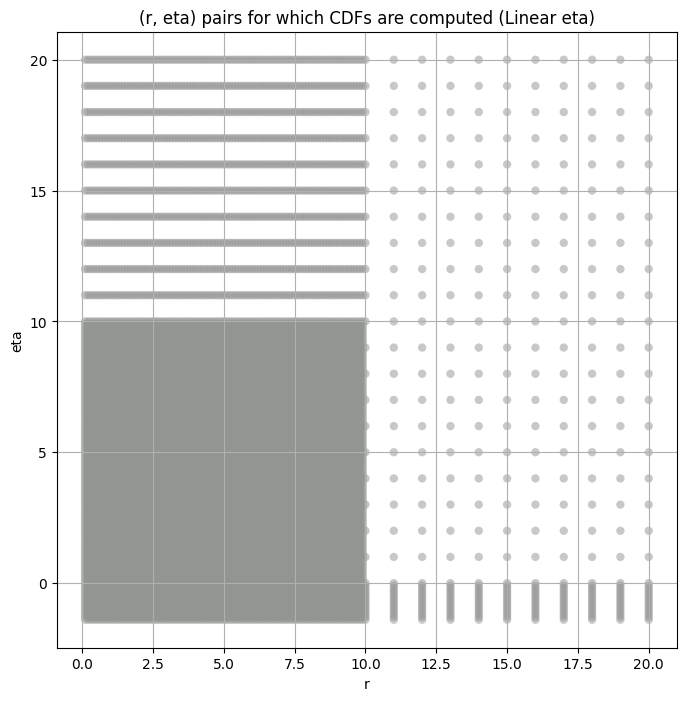

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.012916   0.010740   0.015637   51.336946   22.817850   84.237065   
3     0.217873   0.183152   0.256395   40.707511   32.092322   50.155179   
5     2.125036   1.956604   2.298565    7.816209    6.816256    8.903308   
6     1.609258   1.481443   1.740564    7.801211    6.922563    8.731483   
8     0.152770   0.132943   0.175851   27.798005   17.132469   42.966426   
9     0.036978   0.032694   0.042336   22.935628   11.524374   56.282324   
11    0.023993   0.020252   0.028238   38.839707   27.353085   60.311904   
12    0.010854   0.008915   0.013248   56.986148   35.428190  112.556587   
14    0.000619   0.000500   0.000798   80.241013   36.024888  254.719182   
16    0.000157   0.000108   0.000230  217.729501   92.213630  520.367386   

      total_samples  
band                 
2           98143.0  
3          100000.0  
5          100000.0  
6          100000.0  
8          100000.0  
9          100000.0  
11         100000.0  
12         100000.0  
14         100000.0  
16         100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  var_exclude_75  \
band                                                                            
2     0.012916       0.012916        0.011346        0.010594        0.010080   
3     0.217873       0.217873        0.201262        0.189142        0.179448   
5     2.125036       2.125036        2.078229        2.040341        2.006528   
6     1.609258       1.609258        1.577409        1.550032        1.524988   
8     0.152770       0.152770        0.141114        0.134517        0.129418   
9     0.036978       0.036978        0.034405        0.033155        0.032206   
11    0.023993       0.023993        0.022029        0.020822        0.019854   
12    0.010854       0.010854        0.009703        0.009059        0.008555   
14    0.000619       0.000619        0.000544        0.000507        0.000479   
16    0.000157       0.000157        0.000120        0.000104        0.000092   

      var_exclude_100  var_exclude_150  var_exclude_200  var_exclude_250  \
band                                                                       
2            0.009683         0.009098         0.008651         0.008291   
3            0.171339         0.157654         0.145972         0.136128   
5            1.975353         1.918894         1.867933         1.821383   
6            1.501784         1.459275         1.421015         1.385853   
8            0.125202         0.118373         0.112882         0.108254   
9            0.031416         0.030118         0.029049         0.028126   
11           0.019031         0.017659         0.016531         0.015568   
12           0.008133         0.007441         0.006883         0.006413   
14           0.000455         0.000416         0.000384         0.000358   
16           0.000083         0.000070         0.000060         0.000053   

      var_exclude_300  var_exclude_350  var_exclude_500  
band                                                     
2            0.007991         0.007733         0.007104  
3            0.127706         0.120313         0.102399  
5            1.778172         1.737725         1.630325  
6            1.353155         1.322456         1.240215  
8            0.104229         0.100648         0.091850  
9            0.027307         0.026566         0.024680  
11           0.014728         0.013981         0.012145  
12           0.006008         0.005652         0.004793  
14           0.000335         0.000315         0.000267  
16           0.000047         0.000042         0.000031

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.006773745132438669 0.012916430578182899


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.0031455557208600604 0.011345833092691979


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.0065343532109599645 0.010594316853283693


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.005405198254915589 0.010079626270154388


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0034148945373795314 0.00968258503449374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.003247898822986872 0.009098179974385842


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.0032876743415336494 0.008651022072579539


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.004576062632884403 0.00829113622890422


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.005649084184235931 0.007991021787083061


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.005715842735801186 0.007733085431539346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.007399866750380471 0.0071043174273252695
Number of samples: 100000, Without approximation : 98143.0


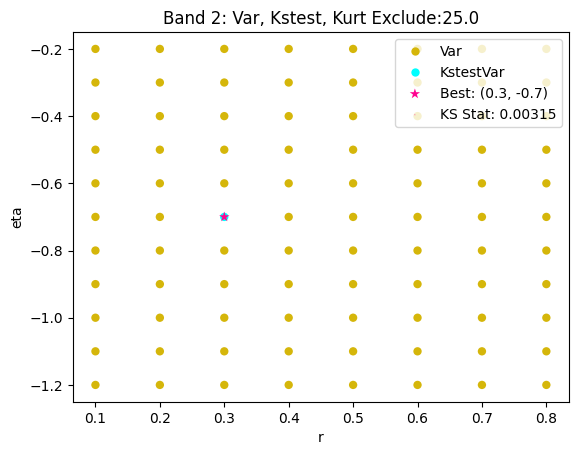

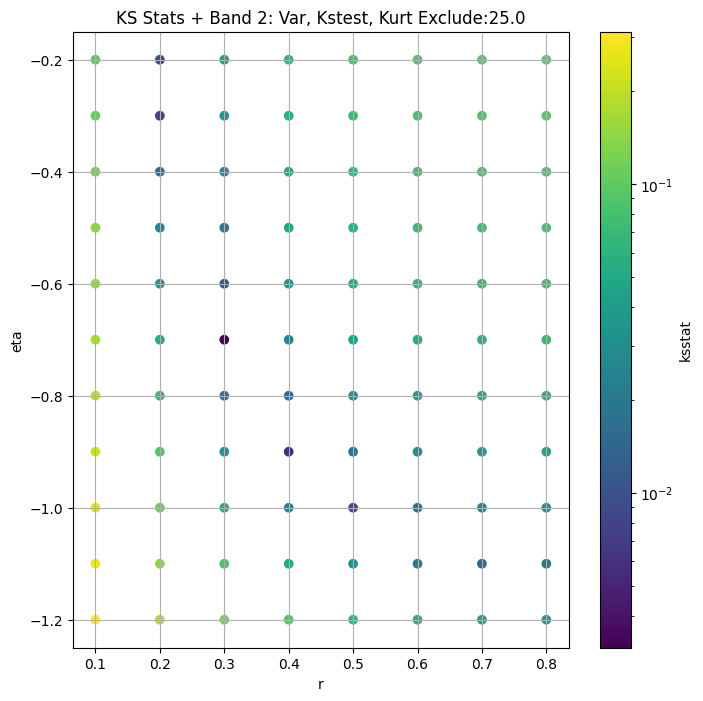

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.023603383374594333 0.21787302932780753


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.01965287868282295 0.20126153832073596


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.016588793651139633 0.18914166190347773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.01679371418819736 0.17944772864862135


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.01804068626148636 0.17133912787190667


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.020481380860432385 0.15765414909801315


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.018894307114944664 0.14597153885225952


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.015281337143938534 0.13612809752515062


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.015737478534292974 0.12770596085010702


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.016554399034112773 0.12031253600556371


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.017550302832705734 0.10239930926280193
Number of samples: 100000, Without approximation : 100000.0


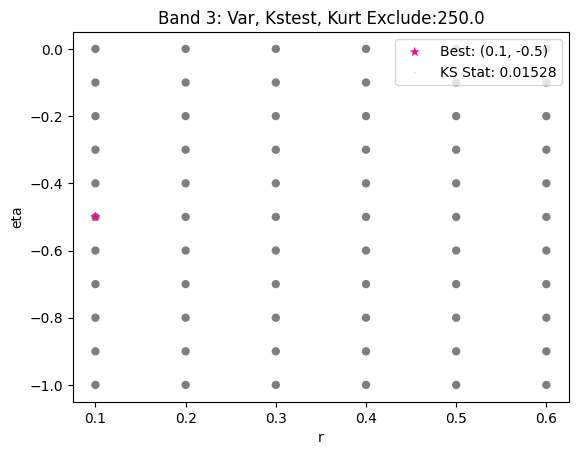

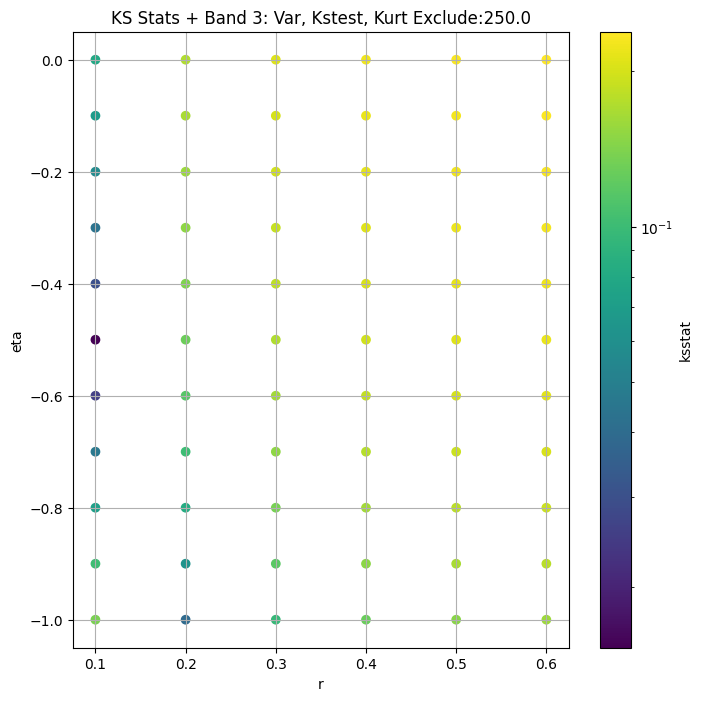

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.011989997659759388 2.1250359663272858


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.01228104736701563 2.0782292752029723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.011470356205984023 2.040341450885016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.010731884045001694 2.006527837439607


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.010534180679225819 1.975352652500009


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.011841920036388731 1.9188940920757152


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.013063604086135813 1.8679326042142046


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.013447230554317513 1.8213826496652827


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.012398613827414584 1.7781722814205254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.013274010449676465 1.737724967733034


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.01397519840146462 1.6303249802414796
Number of samples: 100000, Without approximation : 100000.0


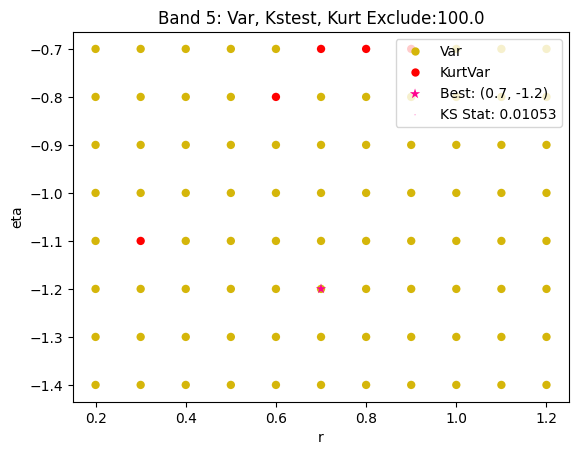

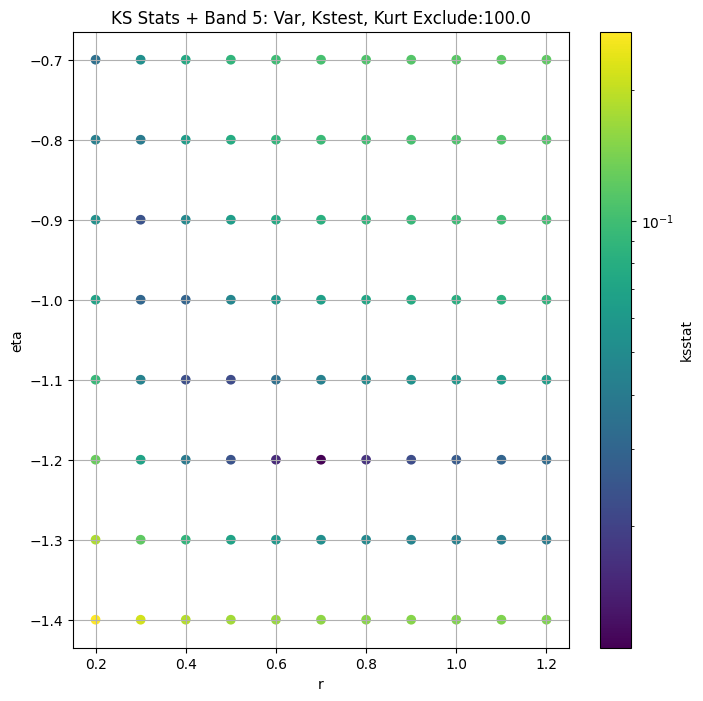

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.011161866797570641 1.6092577647366422


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.011430250364980632 1.5774085730133016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.011666460928196731 1.5500321791087166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.011888963834669586 1.5249881058309085


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.012103448740855116 1.501783883987231


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.01300006649171885 1.4592746852235812


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.014043347966240884 1.4210147256136834


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.013258535938825533 1.3858534307757444


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.01297354820217747 1.353154763408805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.013839567511369388 1.3224564047438336


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.015219589913793019 1.2402150483039793
Number of samples: 100000, Without approximation : 100000.0


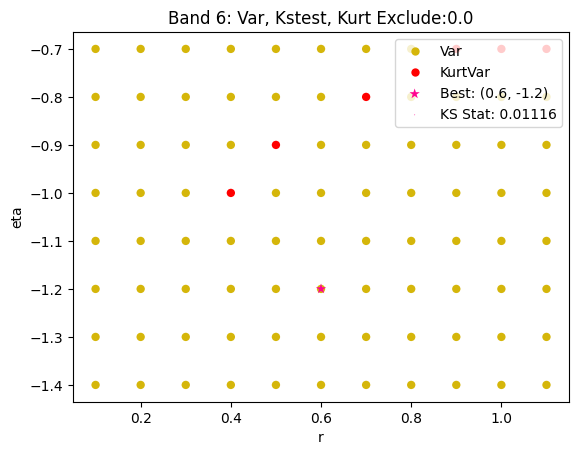

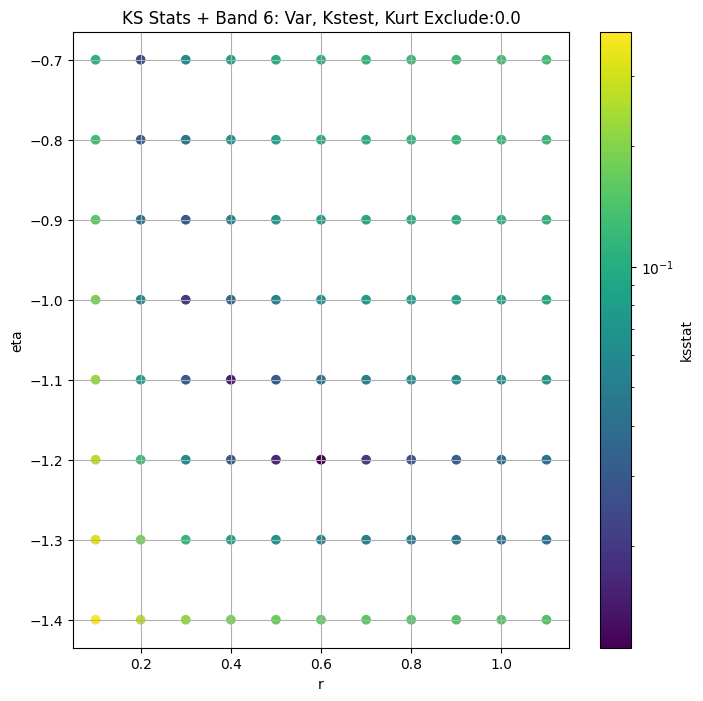

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0038837156621830404 0.15276963488975376


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.005689833618894857 0.14111380434275833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.0055515565537535005 0.1345166767111016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.003690690514800088 0.12941789443635804


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.005235905911853425 0.12520208779840192


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.008185690418365185 0.11837254498874952


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.006439600107883137 0.11288177267636965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.004521427501833097 0.1082537425622295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006125070414883971 0.10422874702477153


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007779706649970949 0.10064849876608532


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008839627540473592 0.09184980043944269
Number of samples: 100000, Without approximation : 100000.0


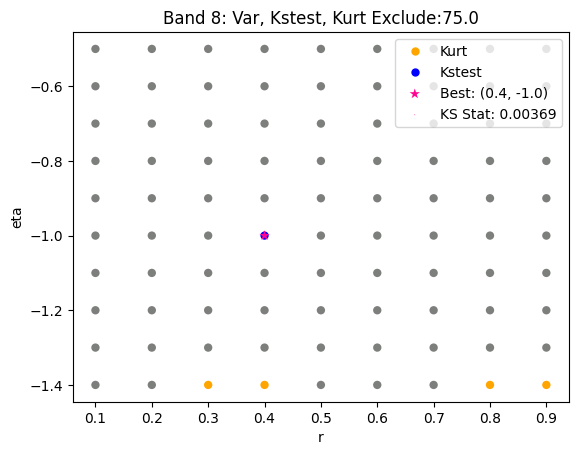

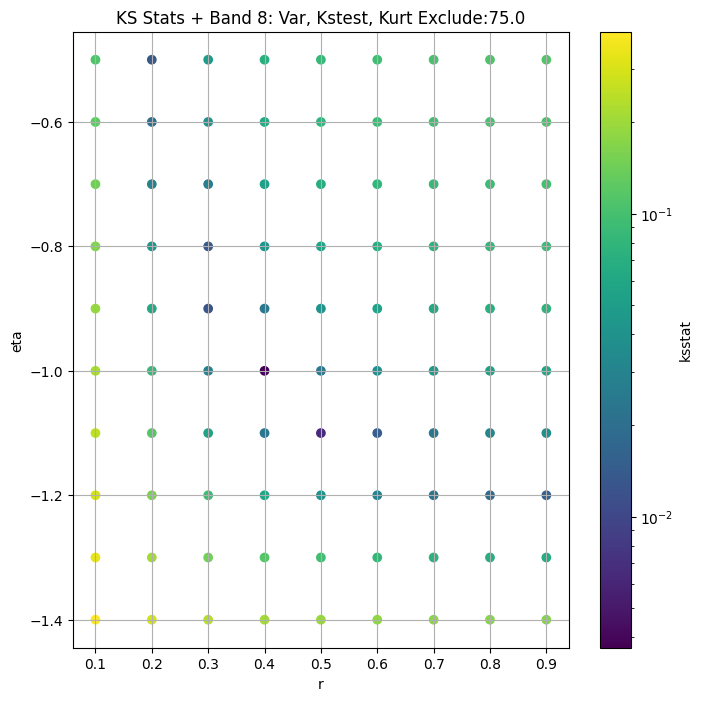

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.004110569512426707 0.036977607083711166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.005257438814060378 0.034405147775638766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.00315329768884276 0.03315480936893079


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.0034573258850500443 0.03220606927190881


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.003987423698599897 0.03141615168655513


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.005801696128512036 0.03011808317488799


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.005241241315828038 0.029049095666038468


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.006182755563725169 0.028126093502234155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.007345276115581778 0.027306525236814403


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.007747940177527335 0.026565524243113595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009404166041234174 0.024679644649225684
Number of samples: 100000, Without approximation : 100000.0


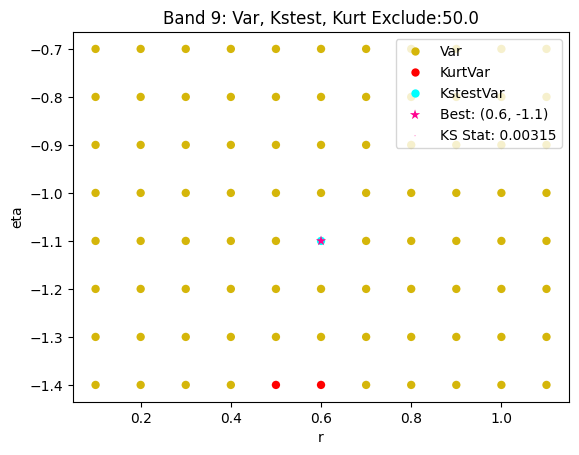

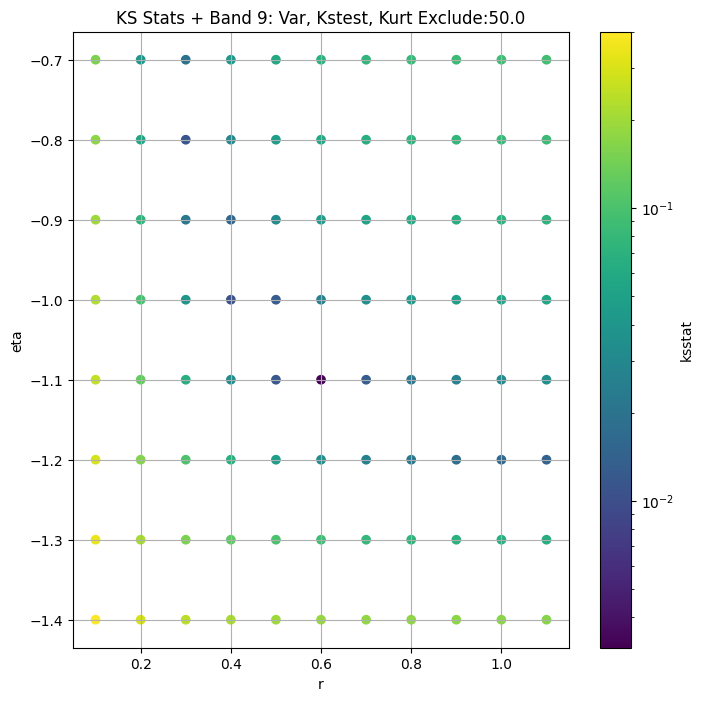

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.008968431377682662 0.023993295691473626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.008602098688251514 0.02202907515211205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.009425703783305095 0.0208215607140723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.010165098825884566 0.019853794354704152


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.010871525459884068 0.019030653336275207


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.01221485106411363 0.01765876425225973


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.013564286472111609 0.0165313152314579


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.014875993693305667 0.01556843705264051


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.012932184301708727 0.01472766086363442


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.01163589514237632 0.013980578665093281


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.011316764029853203 0.012144604319758655
Number of samples: 100000, Without approximation : 100000.0


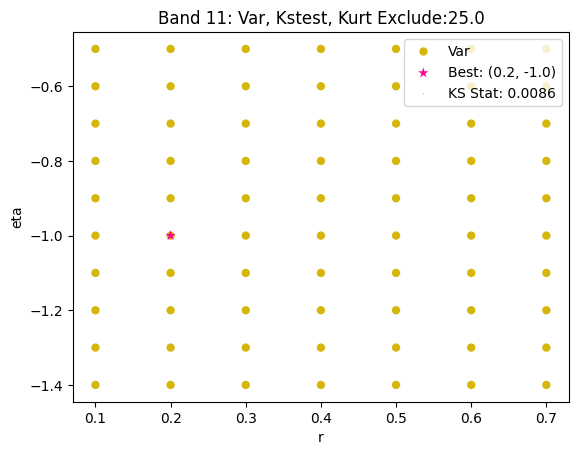

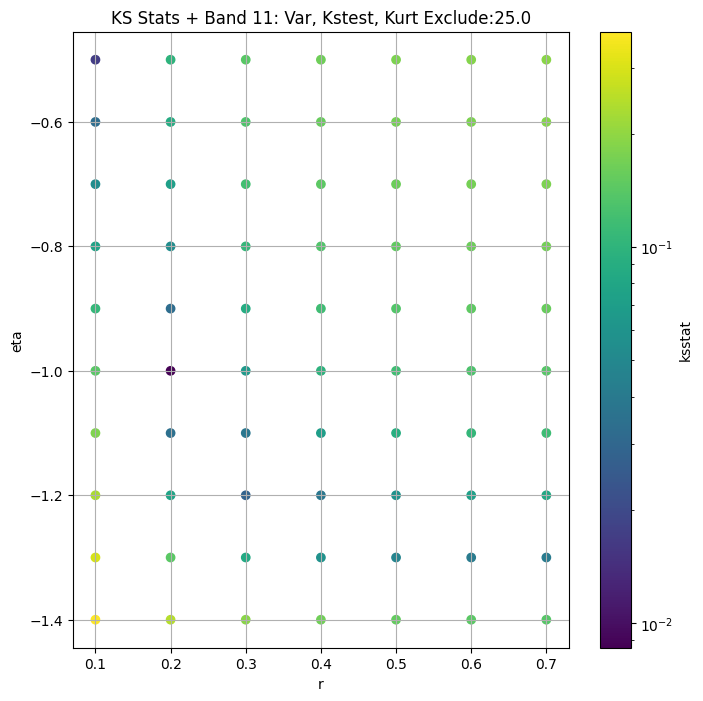

####
Band  12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 0 0.01351519144291452 0.010853995004239695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 25 0.010366777609578381 0.009703234674194762


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 50 0.008430003716585956 0.00905932337065847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 75 0.009331559223557526 0.008555496020936096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 100 0.010155342363732039 0.00813334099624802


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 150 0.010890105987013232 0.007441100433475115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 200 0.011250298221295234 0.006882904123104473


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 250 0.012462390150632482 0.006413474030032584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 300 0.013032577051004912 0.006008107229518517


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 350 0.013181141425907844 0.005652206389618745


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 500 0.01548533758924897 0.004793268195902248
Number of samples: 100000, Without approximation : 100000.0


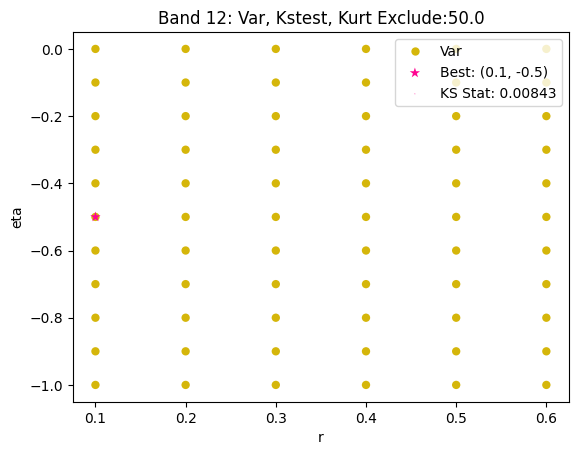

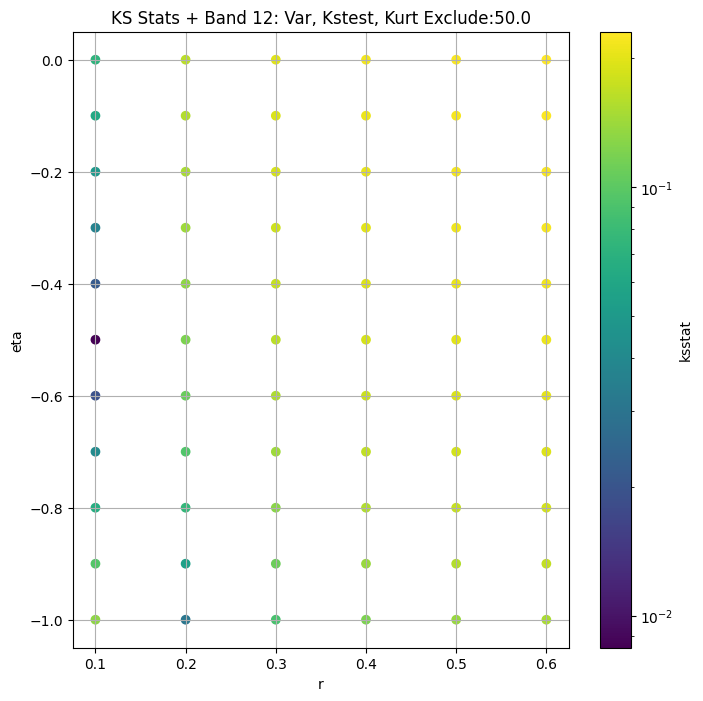

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.01957772810836167 0.0006192494570374825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.01269894603556454 0.0005442416459537702


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.012499667383691127 0.0005073718001223085


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.014370006916803735 0.0004787592155419515


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.01494743703692425 0.00045483127243711334


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.009952406725521112 0.0004157921960482743


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.00966448880229448 0.00038432950407453503


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.012071793975126643 0.00035787302963190433


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.010572219410951145 0.00033506406481410996


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.011550459676521938 0.0003150593772352157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.013394221370529223 0.0002668796498031589
Number of samples: 100000, Without approximation : 100000.0


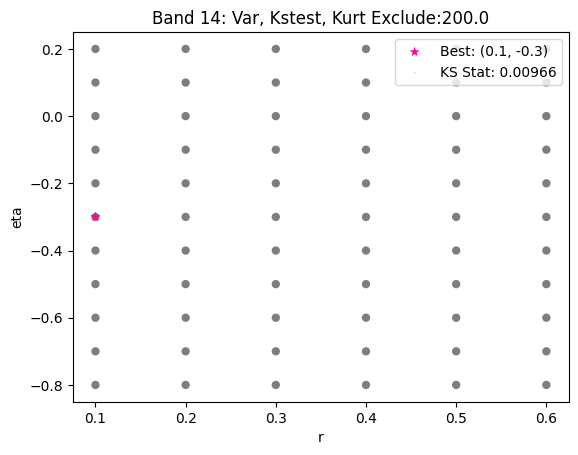

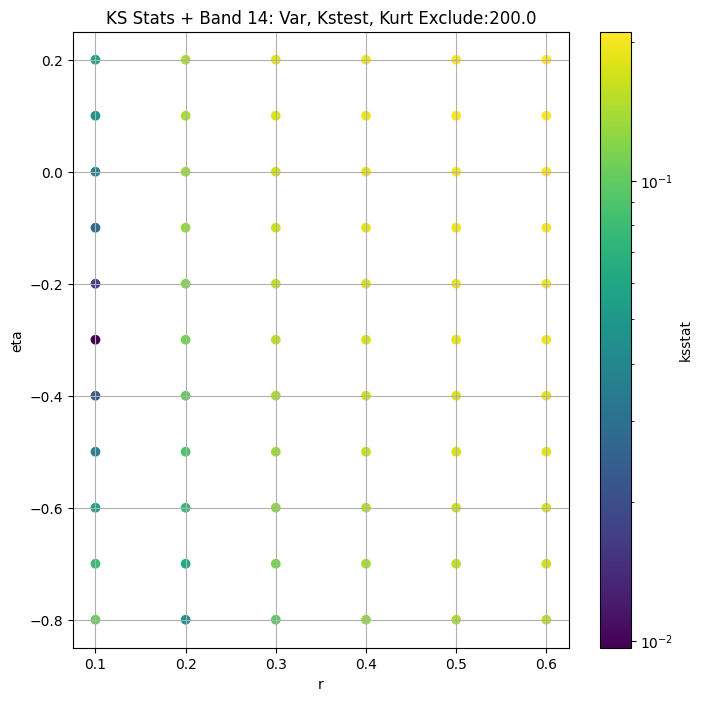

####
Band  16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 0 0.03571437808243594 0.0001568779469370008


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 25 0.028080160812545996 0.00011969816319943489


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 50 0.032535282573922575 0.00010352641671821732


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 75 0.026917725889758715 9.208721371094678e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 100 0.02201783554950454 8.317573562260828e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 150 0.026369525865829302 6.99388017304378e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 200 0.020352450512983622 6.030005058215945e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 250 0.019542913601015954 5.284191371339883e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 300 0.02042344425191167 4.685674078610295e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 350 0.014514528486377132 4.1947757224828674e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 500 0.01095418061842185 3.141781354720531e-05
Number of samples: 100000, Without approximation : 100000.0


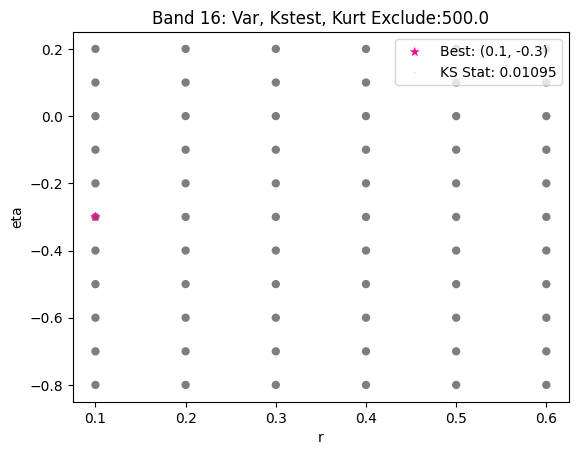

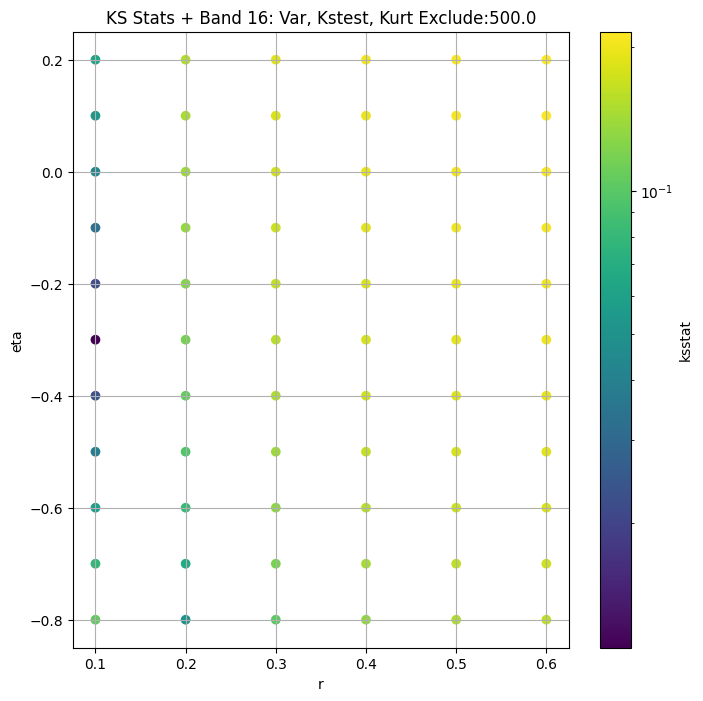

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.012916   0.010740   0.015637   51.336946   22.817850   84.237065   
3     0.217873   0.183152   0.256395   40.707511   32.092322   50.155179   
5     2.125036   1.956604   2.298565    7.816209    6.816256    8.903308   
6     1.609258   1.481443   1.740564    7.801211    6.922563    8.731483   
8     0.152770   0.132943   0.175851   27.798005   17.132469   42.966426   
9     0.036978   0.032694   0.042336   22.935628   11.524374   56.282324   
11    0.023993   0.020252   0.028238   38.839707   27.353085   60.311904   
12    0.010854   0.008915   0.013248   56.986148   35.428190  112.556587   
14    0.000619   0.000500   0.000798   80.241013   36.024888  254.719182   
16    0.000157   0.000108   0.000230  217.729501   92.213630  520.367386   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           98143.0             0.003146        0.3         -0.7   
3          100000.0             0.015281        0.1         -0.5   
5          100000.0             0.010534        0.7         -1.2   
6          100000.0             0.011162        0.6         -1.2   
8          100000.0             0.003691        0.4         -1.0   
9          100000.0             0.003153        0.6         -1.1   
11         100000.0             0.008602        0.2         -1.0   
12         100000.0             0.008430        0.1         -0.5   
14         100000.0             0.009664        0.1         -0.3   
16         100000.0             0.010954        0.1         -0.3   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.422555e-04                    25.0            0.011346   
3      4.060843e-13                   250.0            0.136128   
5      4.308993e+00                   100.0            1.975353   
6      2.635343e+00                     0.0            1.609258   
8      2.652159e-02                    75.0            0.129418   
9      3.770707e-02                    50.0            0.033155   
11     1.564947e-05                    25.0            0.022029   
12     2.702490e-14                    50.0            0.009059   
14     3.002725e-16                   200.0            0.000384   
16     2.454640e-17                   500.0            0.000031   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004333  
3                    0.004293  
5                    0.004293  
6                    0.004293  
8                    0.004293  
9                    0.004293  
11                   0.004293  
12                   0.004293  
14                   0.004293  
16                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 25.0 + 100 = 125, ksstat: 0.002144765639126689, var: 0.009367055734010709


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 25.0 + 75 = 100, ksstat: 0.0016153989074745015, var: 0.00968258503449374


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 25.0 + 50 = 75, ksstat: 0.001848750590008219, var: 0.010079626270154388


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 25.0 + 25 = 50, ksstat: 0.002374028734818845, var: 0.010594316853283693


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 25.0 + 0 = 25, ksstat: 0.0029314676330008393, var: 0.011345833092691979


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 25.0 + -25 = 0, ksstat: 0.003823424945752829, var: 0.012916430578182899
Number of samples: 100000, Without approximation : 98143.0


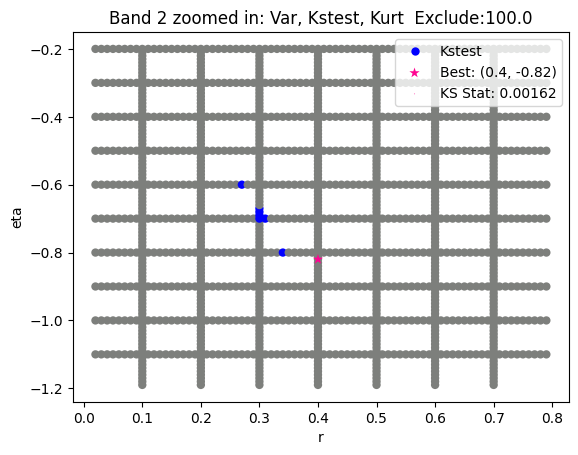

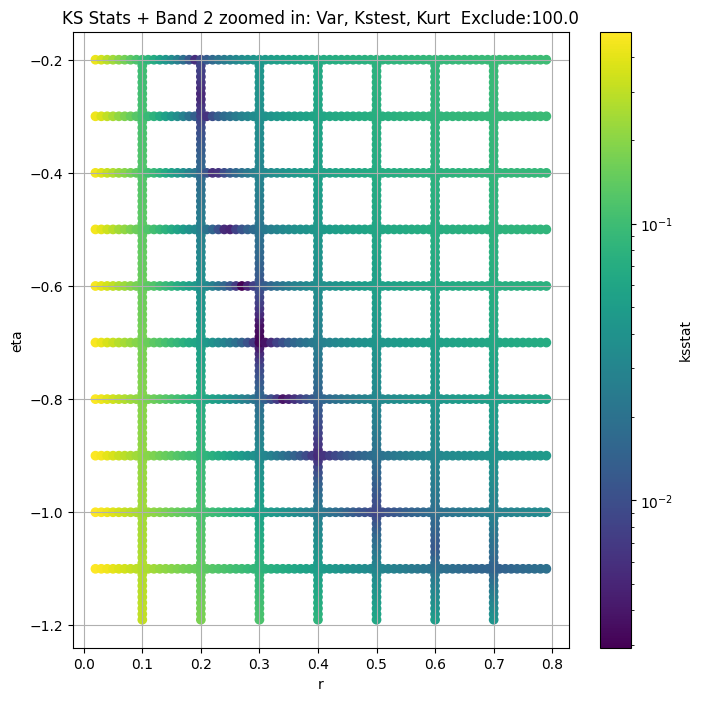

Band 3


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 250.0 + 100 = 350, ksstat: 0.015944182058440837, var: 0.12031253600556371


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 250.0 + 75 = 325, ksstat: 0.015659352384189033, var: 0.1239006849078924


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 250.0 + 50 = 300, ksstat: 0.015230990981944813, var: 0.12770596085010702


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 250.0 + 25 = 275, ksstat: 0.014574420559673174, var: 0.13177381675826202


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 250.0 + 0 = 250, ksstat: 0.014981163206436915, var: 0.13612809752515062


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 250.0 + -25 = 225, ksstat: 0.014642680753856354, var: 0.14085194974374182


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 250.0 + -50 = 200, ksstat: 0.014442026022663975, var: 0.14597153885225952


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 250.0 + -75 = 175, ksstat: 0.014059415572480808, var: 0.15159446398323048


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 250.0 + -100 = 150, ksstat: 0.014386081053078759, var: 0.15765414909801315
Number of samples: 100000, Without approximation : 100000.0


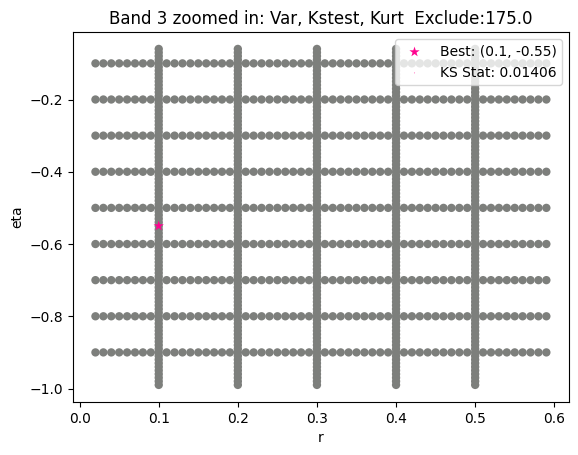

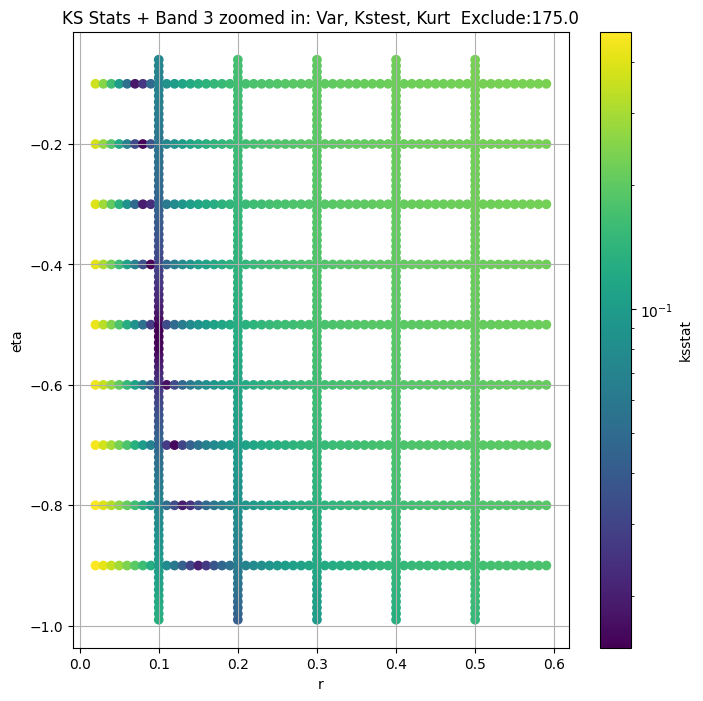

Band 5


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.010698571652900515, var: 1.8679326042142046


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.011097797566553047, var: 1.8928165438710358


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.011082881472587514, var: 1.9188940920757152


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.010846154638996366, var: 1.9462995488931965


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.010534180679225819, var: 1.975352652500009


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.010197706592892541, var: 2.006527837439607


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.009828845626487212, var: 2.040341450885016


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.009735592262483328, var: 2.0782292752029723


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.009240212958026517, var: 2.1250359663272858
Number of samples: 100000, Without approximation : 100000.0


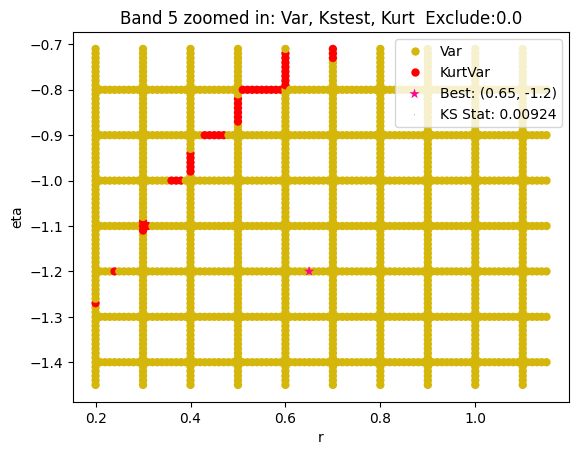

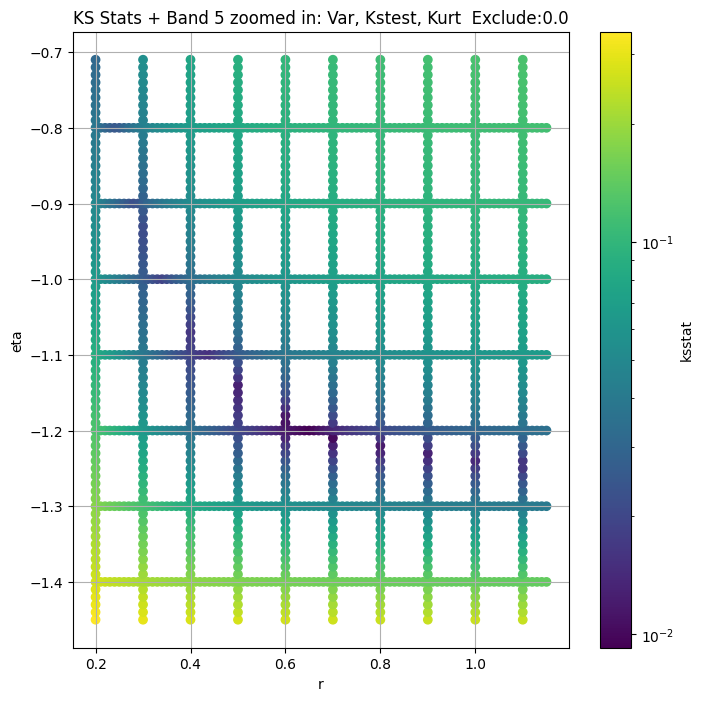

Band 6


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 100 = 100, ksstat: 0.010907014017105518, var: 1.501783883987231


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 75 = 75, ksstat: 0.01106725874895148, var: 1.5249881058309085


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 50 = 50, ksstat: 0.010947783377302067, var: 1.5500321791087166


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 25 = 25, ksstat: 0.011019021885939229, var: 1.5774085730133016


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 0 = 0, ksstat: 0.011161866797570641, var: 1.6092577647366422
Number of samples: 100000, Without approximation : 100000.0


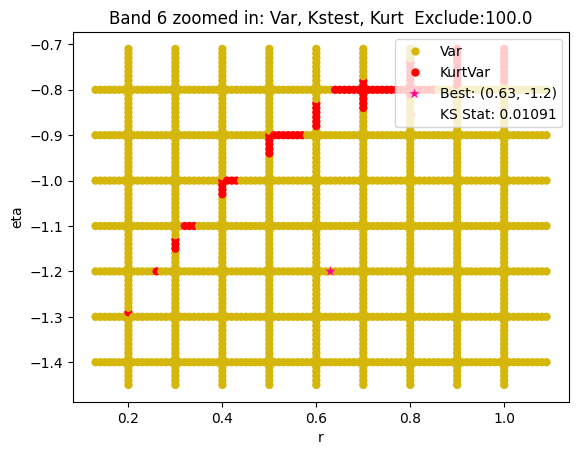

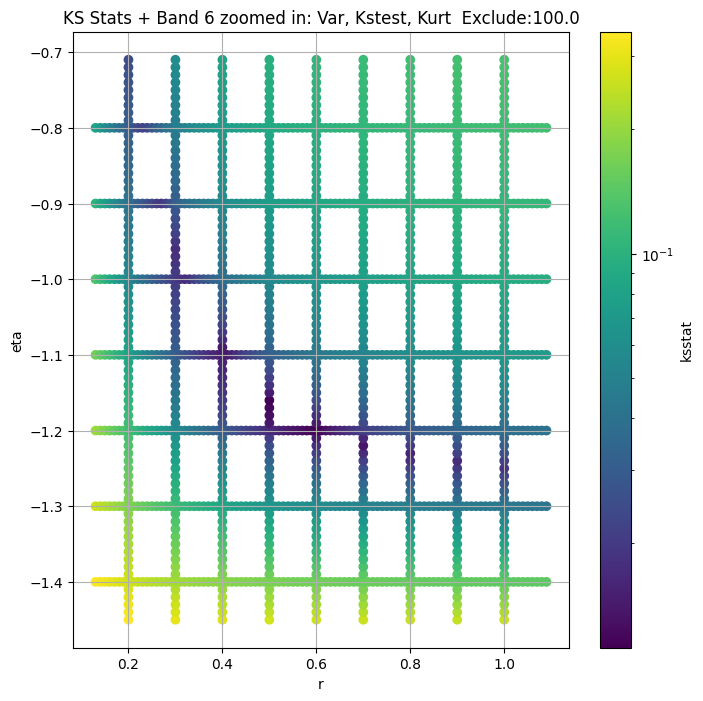

Band 8


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 75.0 + 100 = 175, ksstat: 0.004082026373388836, var: 0.11549663552006366


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 75.0 + 75 = 150, ksstat: 0.0037269057396392413, var: 0.11837254498874952


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 75.0 + 50 = 125, ksstat: 0.003440028769969128, var: 0.12157049312629359


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 75.0 + 25 = 100, ksstat: 0.0034053748940773287, var: 0.12520208779840192


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 75.0 + 0 = 75, ksstat: 0.003690690514800088, var: 0.12941789443635804


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 75.0 + -25 = 50, ksstat: 0.0031006737187769112, var: 0.1345166767111016


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 75.0 + -50 = 25, ksstat: 0.001681581422958045, var: 0.14111380434275833


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 8, 75.0 + -75 = 0, ksstat: 0.002095917943307102, var: 0.15276963488975376
Number of samples: 100000, Without approximation : 100000.0


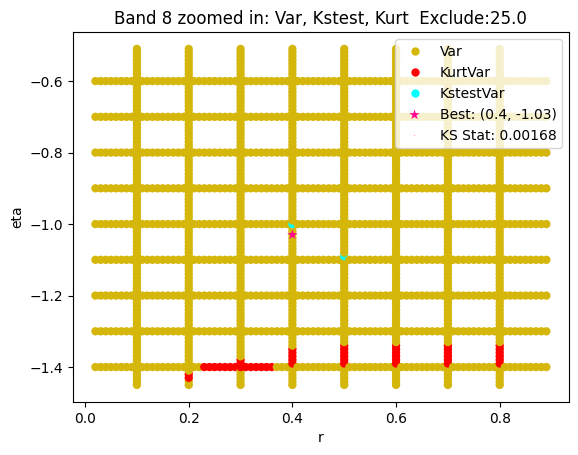

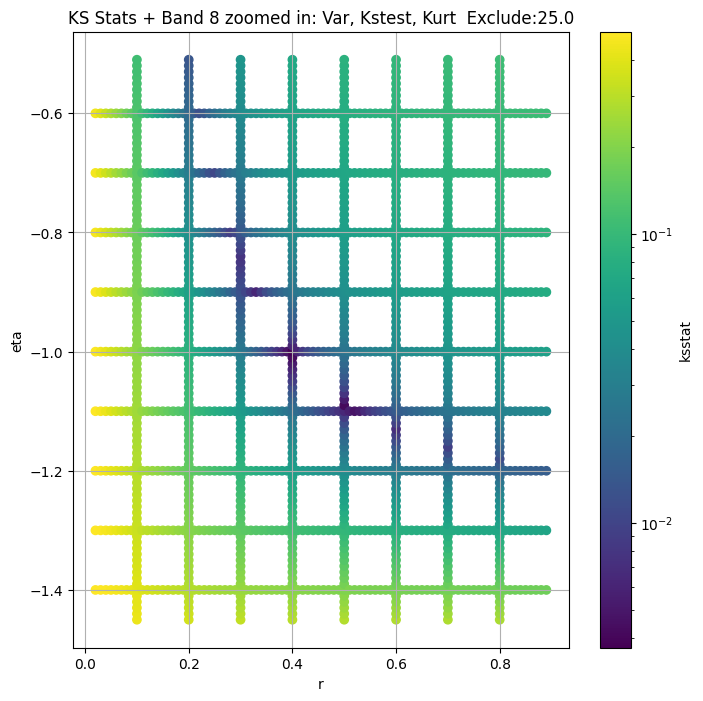

Band 9


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 100 = 150, ksstat: 0.004267895222799717, var: 0.03011808317488799


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 75 = 125, ksstat: 0.0038467214950236306, var: 0.030730248875088826


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 50 = 100, ksstat: 0.003261452176771984, var: 0.03141615168655513


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 25 = 75, ksstat: 0.0031531535554021883, var: 0.03220606927190881


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 0 = 50, ksstat: 0.00315329768884276, var: 0.03315480936893079


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + -25 = 25, ksstat: 0.002589930038093699, var: 0.034405147775638766


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + -50 = 0, ksstat: 0.0026538050501695443, var: 0.036977607083711166
Number of samples: 100000, Without approximation : 100000.0


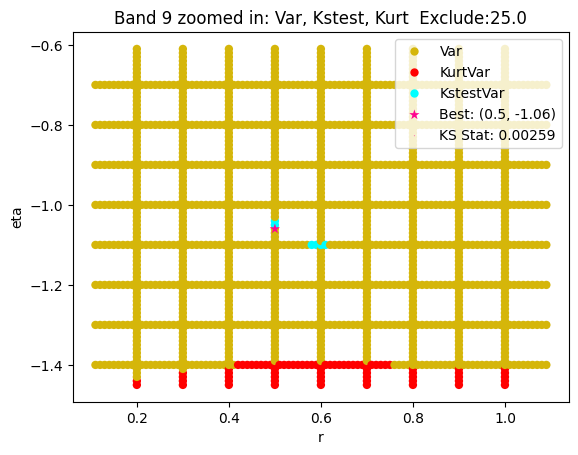

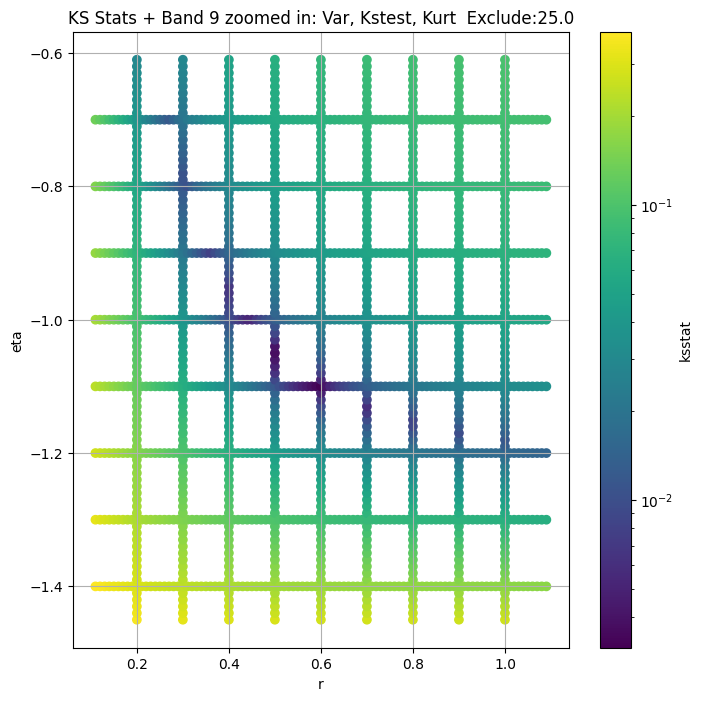

Band 11


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 100 = 125, ksstat: 0.007569648056904611, var: 0.018307006511247063


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 75 = 100, ksstat: 0.0075805794044288, var: 0.019030653336275207


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 50 = 75, ksstat: 0.007415890783686874, var: 0.019853794354704152


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 25 = 50, ksstat: 0.007256097318098086, var: 0.0208215607140723


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 0 = 25, ksstat: 0.0060351018723494194, var: 0.02202907515211205


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + -25 = 0, ksstat: 0.006899200457819513, var: 0.023993295691473626
Number of samples: 100000, Without approximation : 100000.0


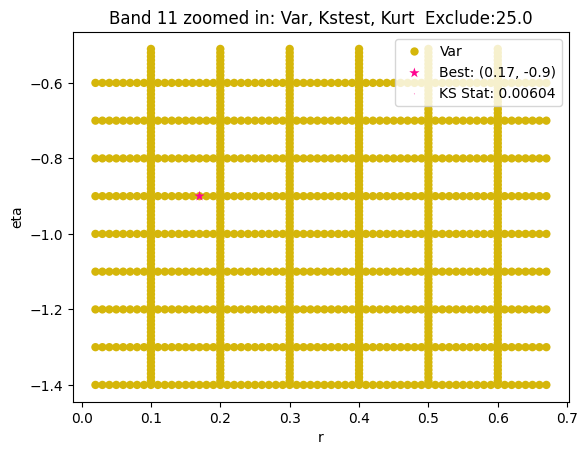

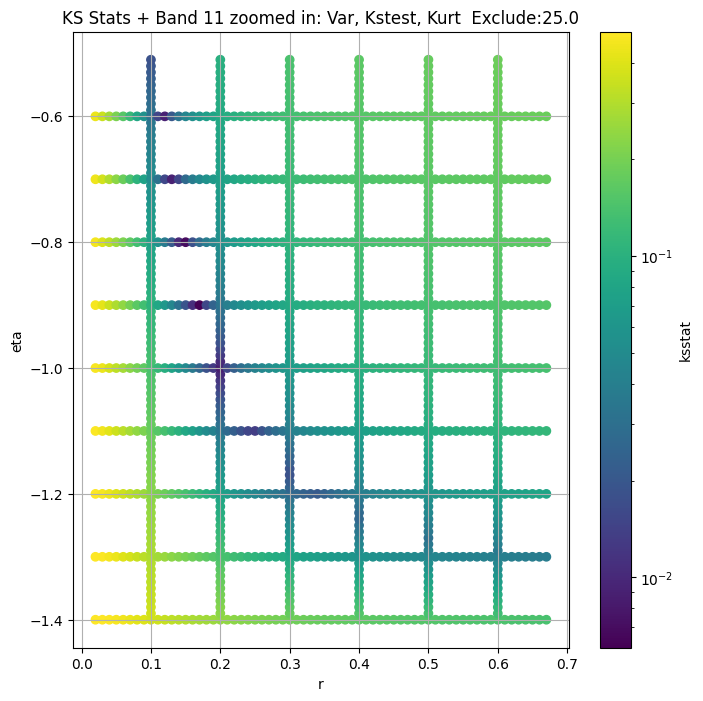

Band 12


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 100 = 150, ksstat: 0.009552035043517038, var: 0.007441100433475115


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 75 = 125, ksstat: 0.008667786559555801, var: 0.007766423628400529


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 50 = 100, ksstat: 0.009315414471980085, var: 0.00813334099624802


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 25 = 75, ksstat: 0.00874317157571887, var: 0.008555496020936096


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 0 = 50, ksstat: 0.008157902016314778, var: 0.00905932337065847


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + -25 = 25, ksstat: 0.007707579241484814, var: 0.009703234674194762


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + -50 = 0, ksstat: 0.007825659550415476, var: 0.010853995004239695
Number of samples: 100000, Without approximation : 100000.0


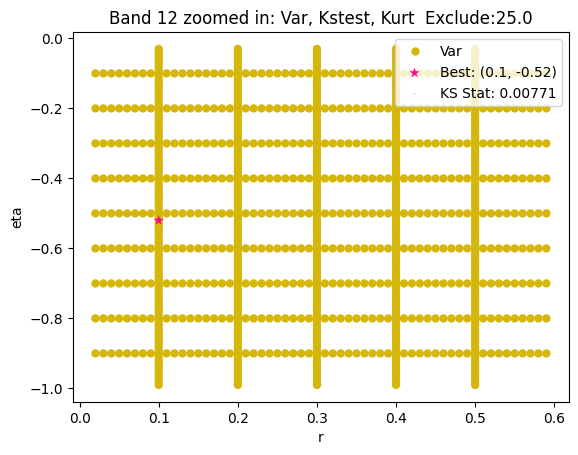

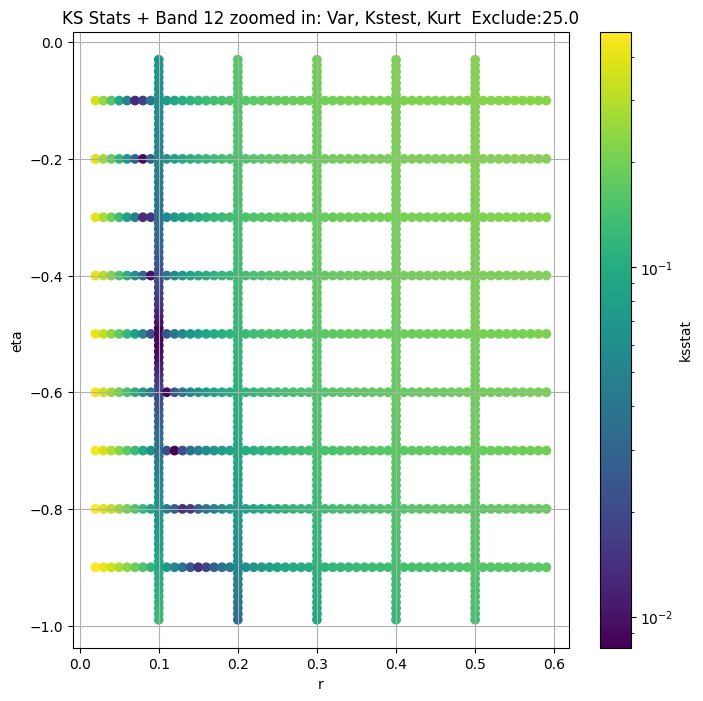

Band 14


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 100 = 300, ksstat: 0.010485495086816864, var: 0.00033506406481410996


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 75 = 275, ksstat: 0.010169250623983543, var: 0.00034607502779090065


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 50 = 250, ksstat: 0.00984076720064608, var: 0.00035787302963190433


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 25 = 225, ksstat: 0.009088909548745194, var: 0.0003705739975460321


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 0 = 200, ksstat: 0.009143817584146528, var: 0.00038432950407453503


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -25 = 175, ksstat: 0.008845138751393034, var: 0.00039931662452199286


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -50 = 150, ksstat: 0.008801654138198112, var: 0.0004157921960482743


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -75 = 125, ksstat: 0.00878066798497951, var: 0.0004341119336491652


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -100 = 100, ksstat: 0.008544885967156746, var: 0.00045483127243711334
Number of samples: 100000, Without approximation : 100000.0


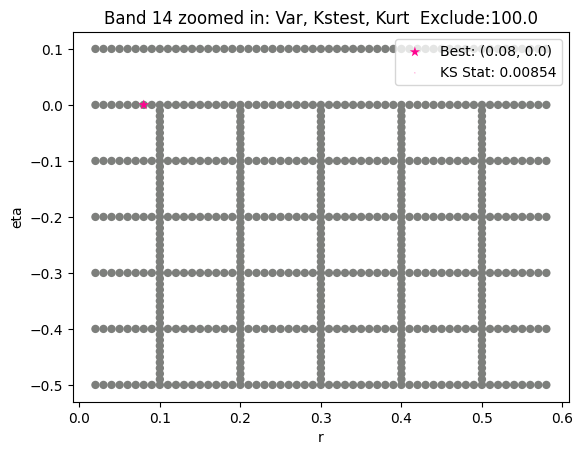

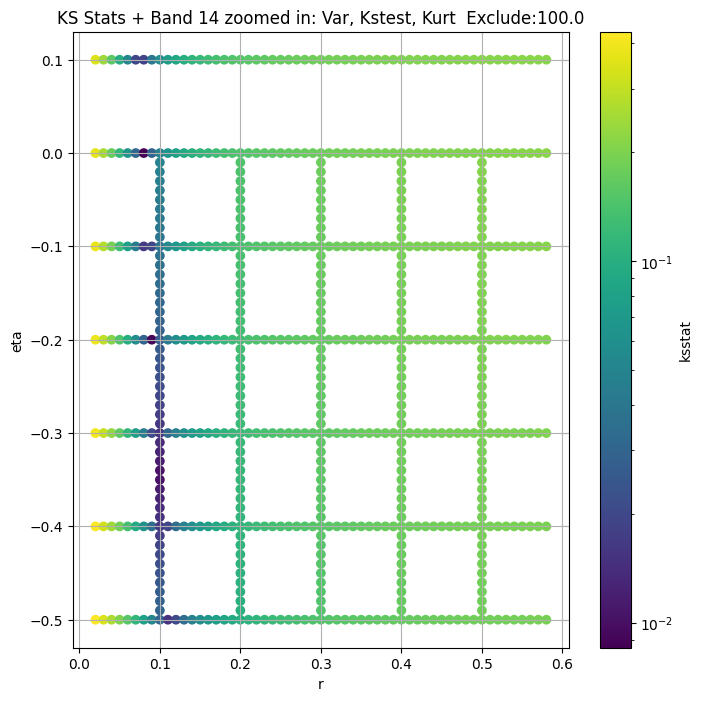

Band 16


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 100 = 600, ksstat: 0.010388334702477353, var: 2.661153890528914e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 75 = 575, ksstat: 0.010082547162616012, var: 2.76932678265474e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 50 = 550, ksstat: 0.009904932578688757, var: 2.8849260385387823e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 25 = 525, ksstat: 0.010613683134171437, var: 3.0088095831811274e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 0 = 500, ksstat: 0.01095418061842185, var: 3.141781354720531e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -25 = 475, ksstat: 0.011743278989412742, var: 3.284635922605904e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -50 = 450, ksstat: 0.010489817682756974, var: 3.438643887646763e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -75 = 425, ksstat: 0.011674237391670506, var: 3.604933352519913e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -100 = 400, ksstat: 0.013037094715878661, var: 3.785094078463127e-05
Number of samples: 100000, Without approximation : 100000.0


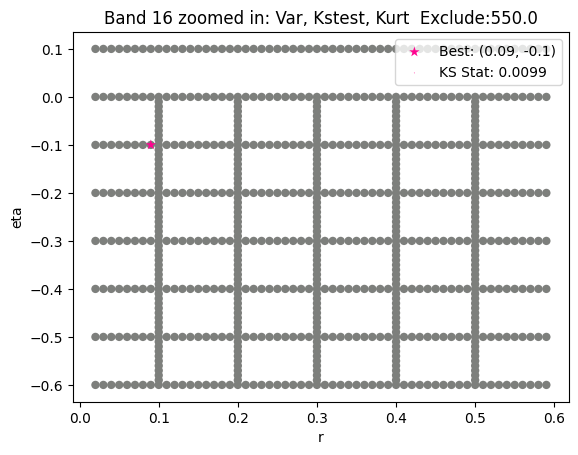

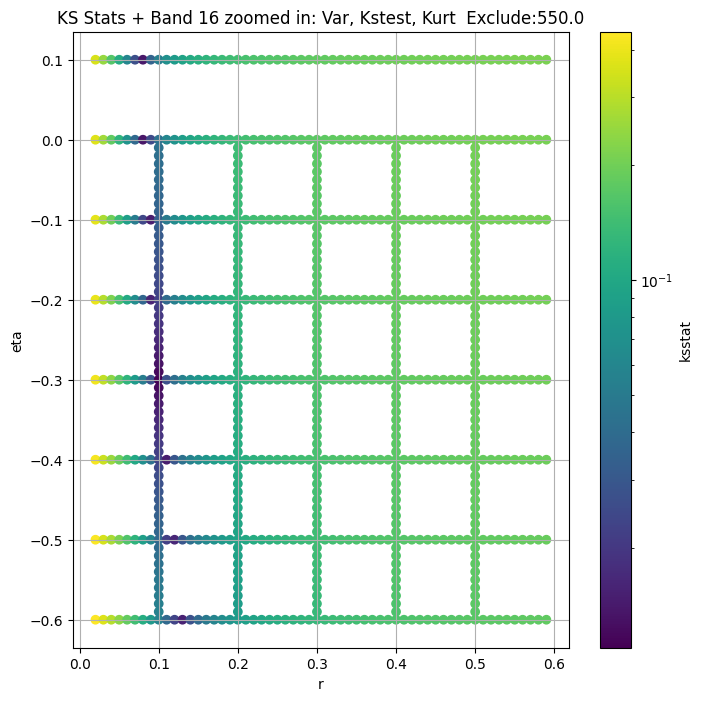

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.012916   0.010740   0.015637   51.336946   22.817850   84.237065   
3     0.217873   0.183152   0.256395   40.707511   32.092322   50.155179   
5     2.125036   1.956604   2.298565    7.816209    6.816256    8.903308   
6     1.609258   1.481443   1.740564    7.801211    6.922563    8.731483   
8     0.152770   0.132943   0.175851   27.798005   17.132469   42.966426   
9     0.036978   0.032694   0.042336   22.935628   11.524374   56.282324   
11    0.023993   0.020252   0.028238   38.839707   27.353085   60.311904   
12    0.010854   0.008915   0.013248   56.986148   35.428190  112.556587   
14    0.000619   0.000500   0.000798   80.241013   36.024888  254.719182   
16    0.000157   0.000108   0.000230  217.729501   92.213630  520.367386   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           98143.0             0.003146        0.3         -0.7   
3          100000.0             0.015281        0.1         -0.5   
5          100000.0             0.010534        0.7         -1.2   
6          100000.0             0.011162        0.6         -1.2   
8          100000.0             0.003691        0.4         -1.0   
9          100000.0             0.003153        0.6         -1.1   
11         100000.0             0.008602        0.2         -1.0   
12         100000.0             0.008430        0.1         -0.5   
14         100000.0             0.009664        0.1         -0.3   
16         100000.0             0.010954        0.1         -0.3   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.422555e-04                    25.0            0.009683   
3      4.060843e-13                   250.0            0.151594   
5      4.308993e+00                   100.0            2.125036   
6      2.635343e+00                     0.0            1.501784   
8      2.652159e-02                    75.0            0.141114   
9      3.770707e-02                    50.0            0.034405   
11     1.564947e-05                    25.0            0.022029   
12     2.702490e-14                    50.0            0.009703   
14     3.002725e-16                   200.0            0.000455   
16     2.454640e-17                   500.0            0.000029   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004333          0.001615    0.40     -0.82   
3                    0.004293          0.014059    0.10     -0.55   
5                    0.004293          0.009240    0.65     -1.20   
6                    0.004293          0.010907    0.63     -1.20   
8                    0.004293          0.001682    0.40     -1.03   
9                    0.004293          0.002590    0.50     -1.06   
11                   0.004293          0.006035    0.17     -0.90   
12                   0.004293          0.007708    0.10     -0.52   
14                   0.004293          0.008545    0.08      0.00   
16                   0.004293          0.009905    0.09     -0.10   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     1.134243e-03                100.0       745269  
3     6.522820e-13                175.0         9375  
5     4.077534e+00                  0.0        21093  
6     2.715783e+00                100.0        15819  
8     3.222775e-02                 25.0       640720  
9     2.079615e-02                 25.0       284764  
11    7.693813e-07                 25.0        50000  
12    3.345721e-14                 25.0        31639  
14    2.253919e-21                100.0        25000  
16    8.284157e-20                550.

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

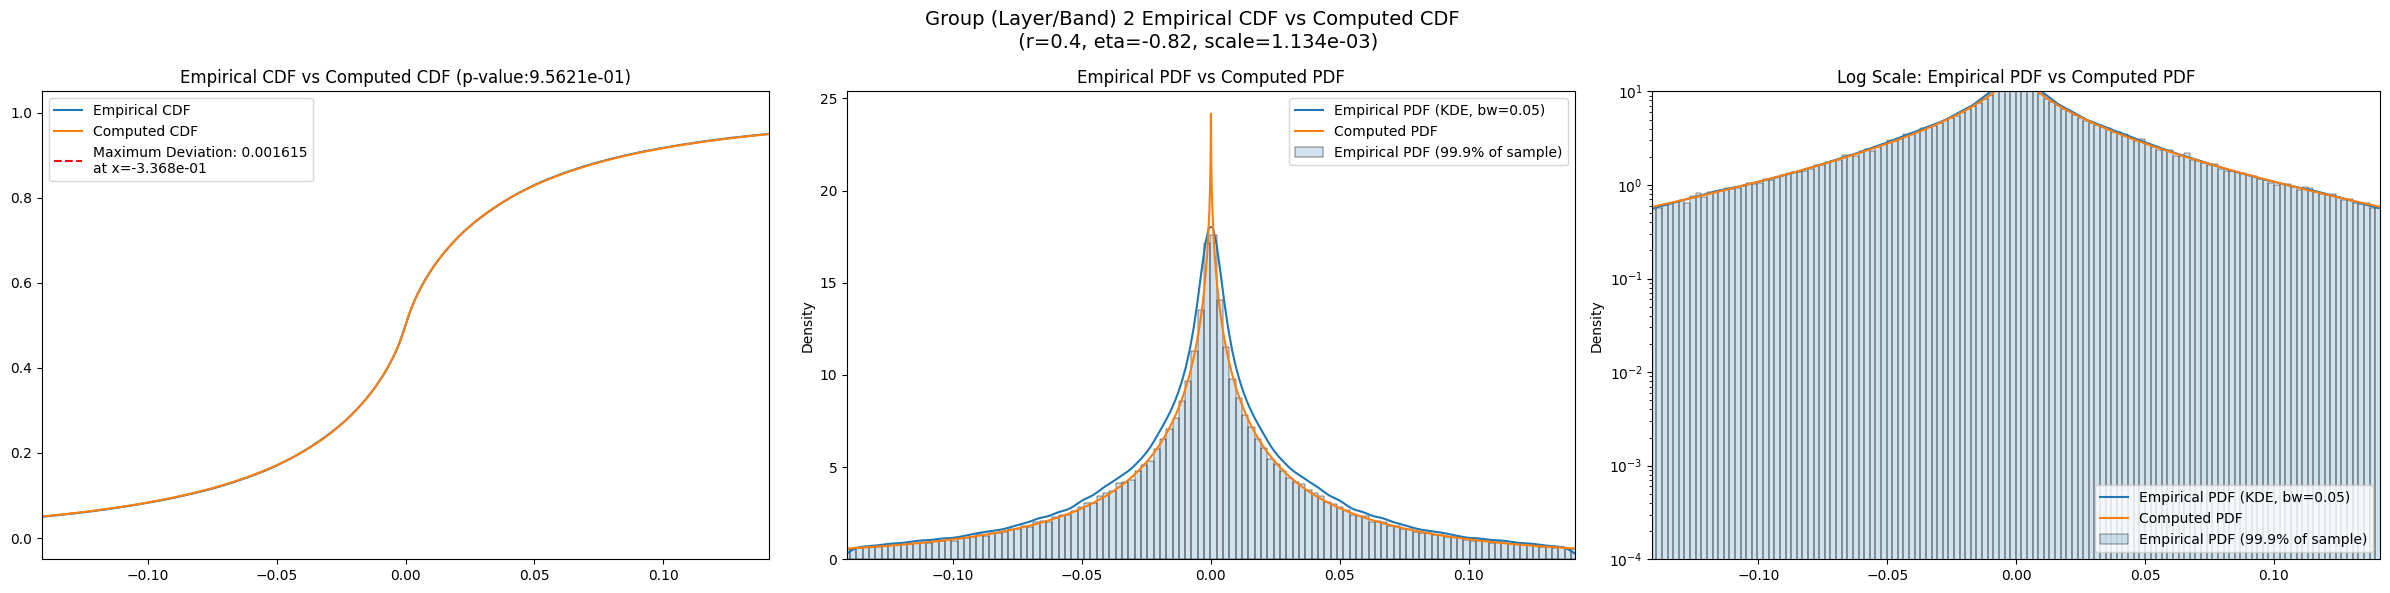

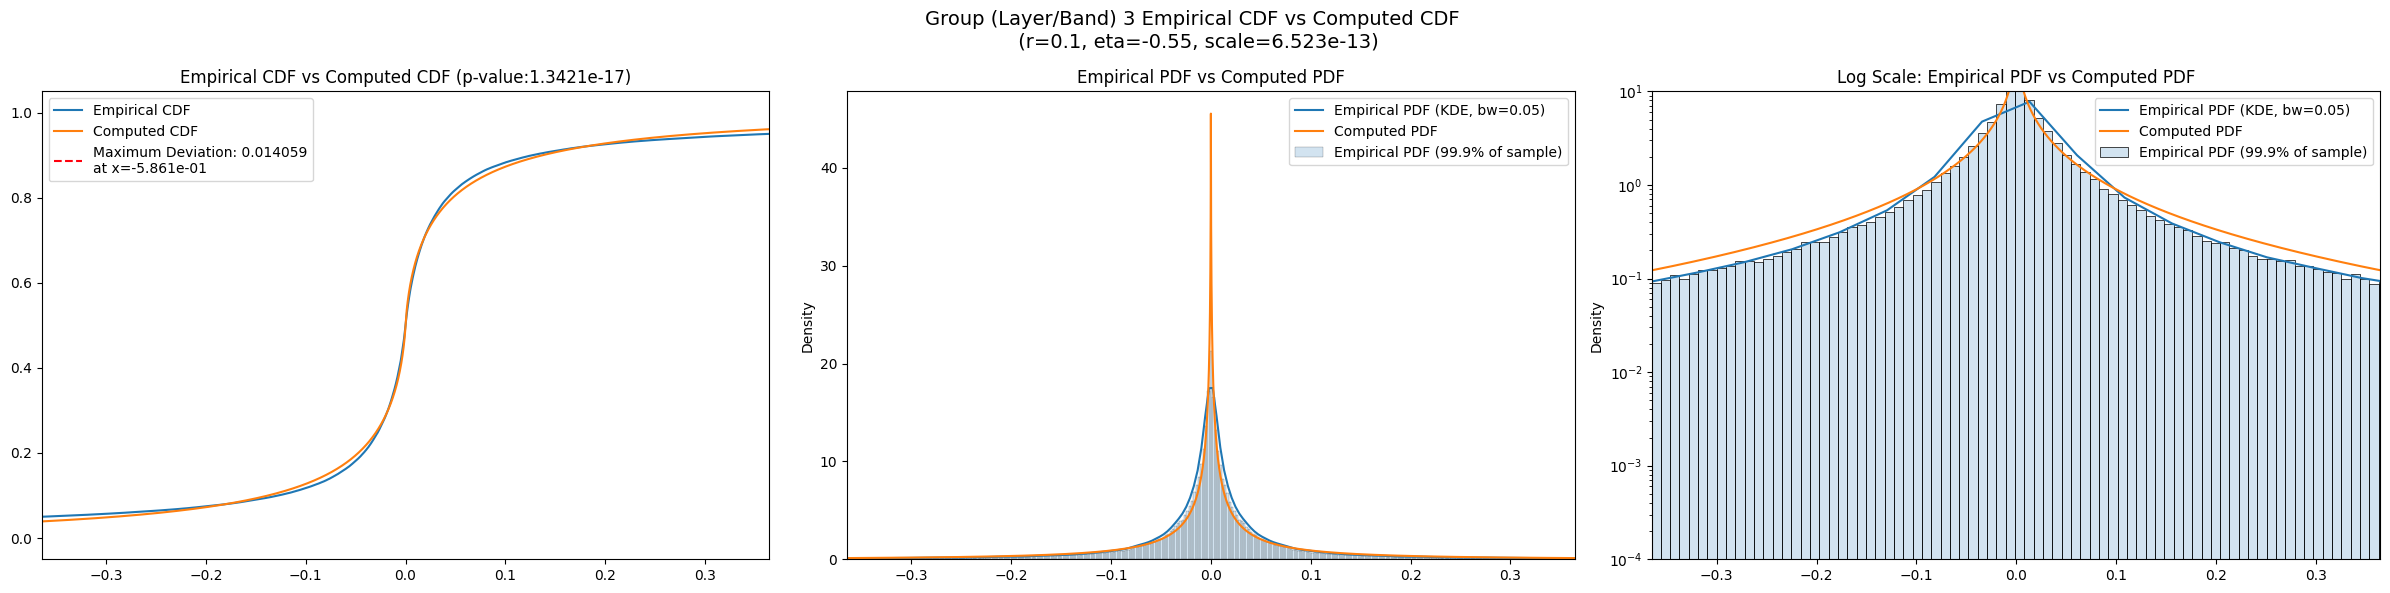

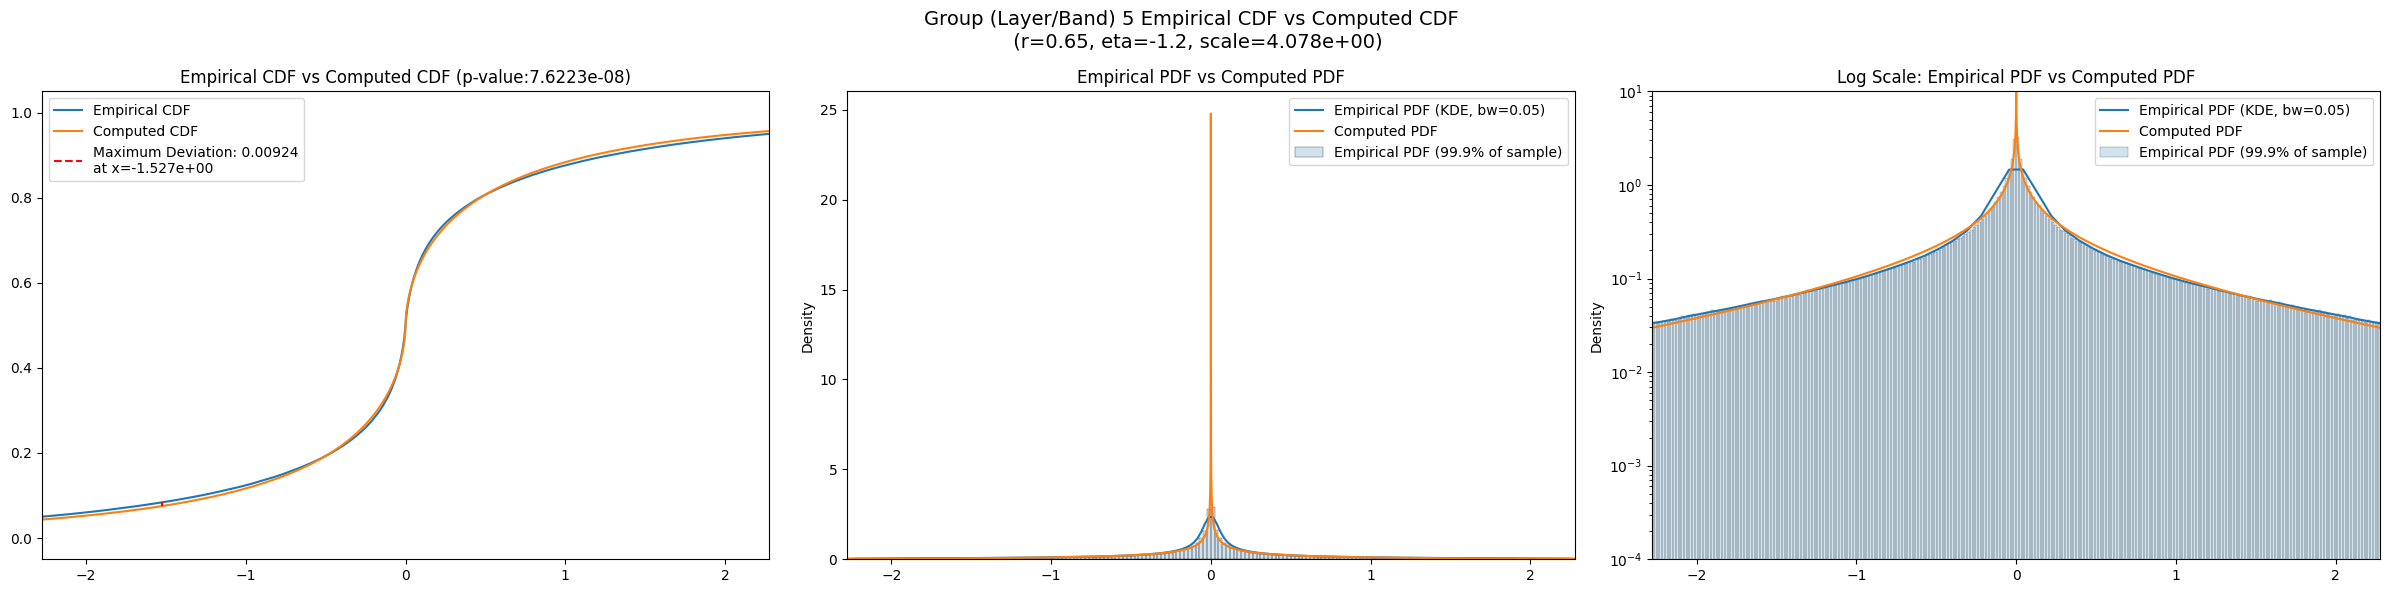

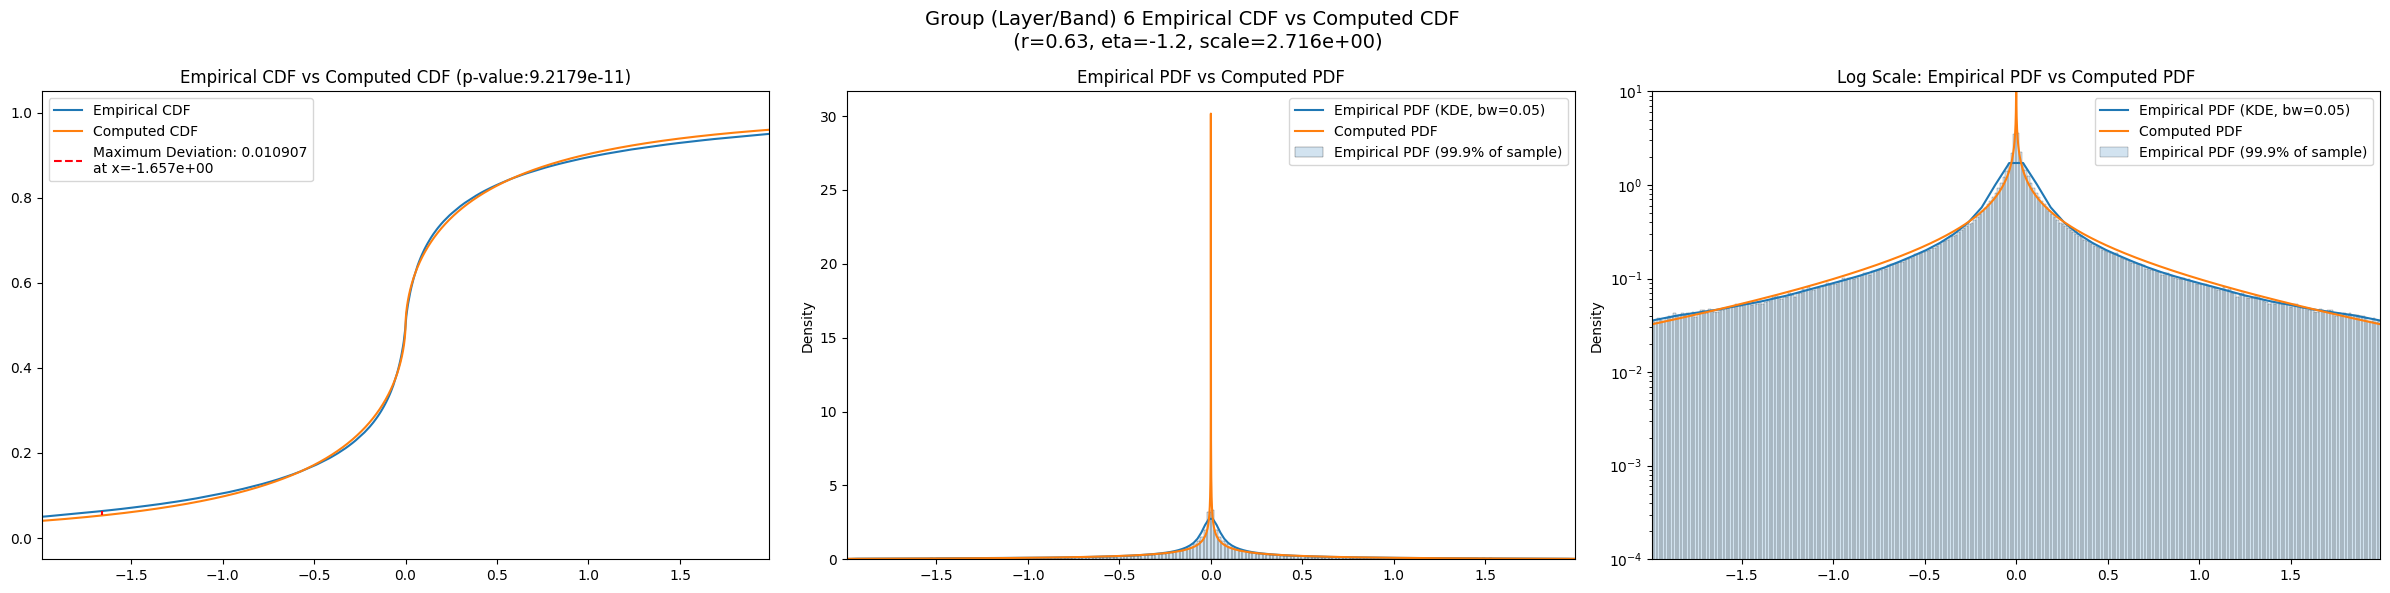

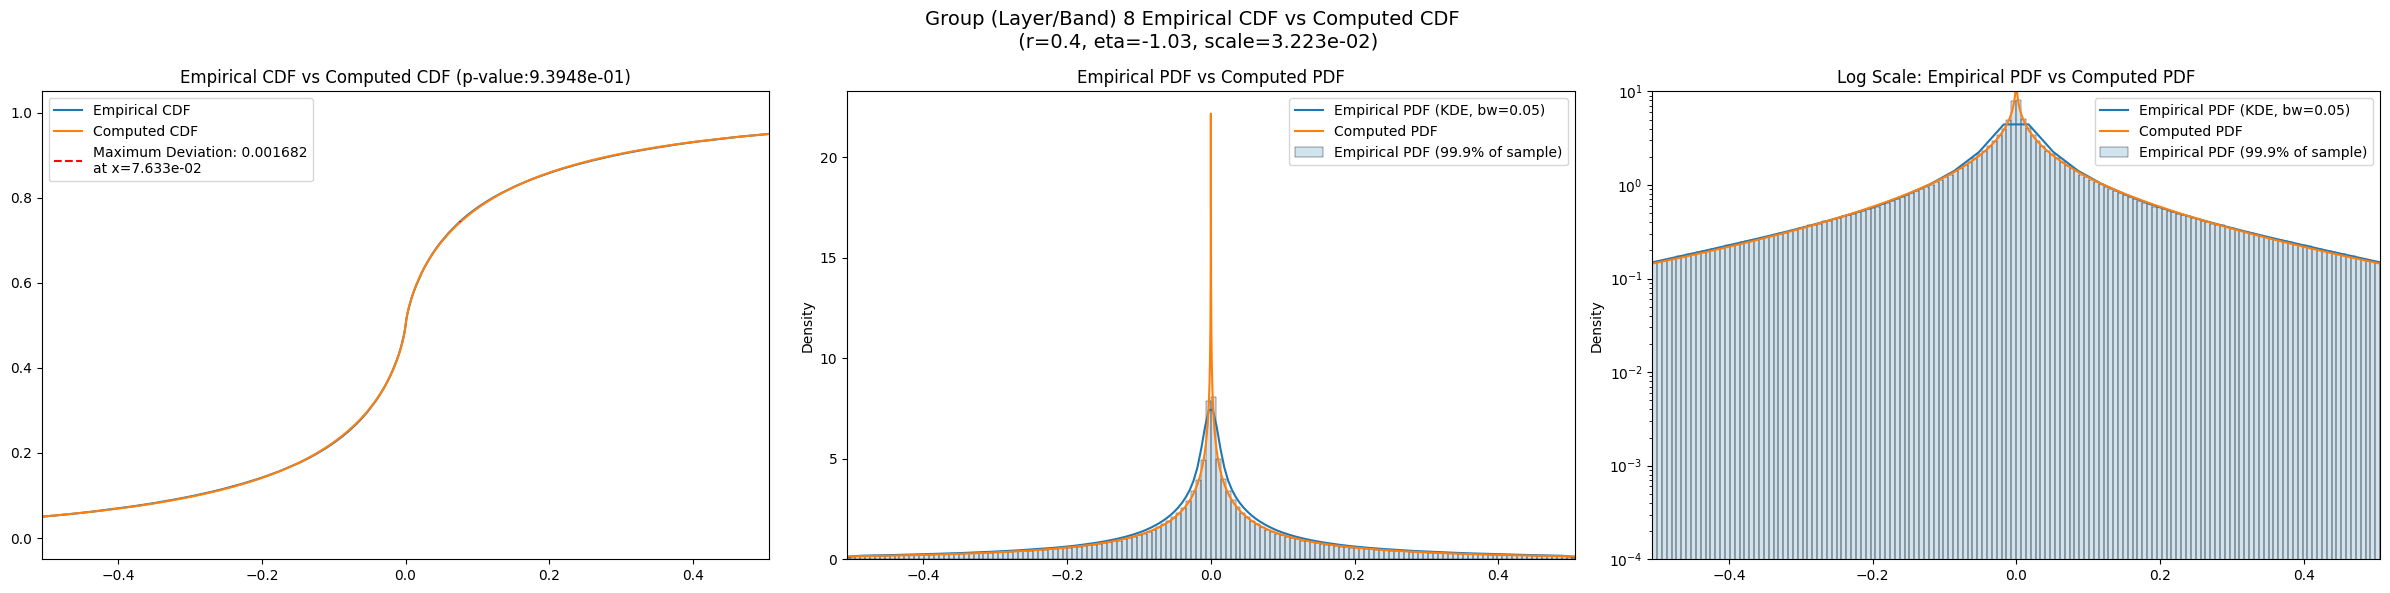

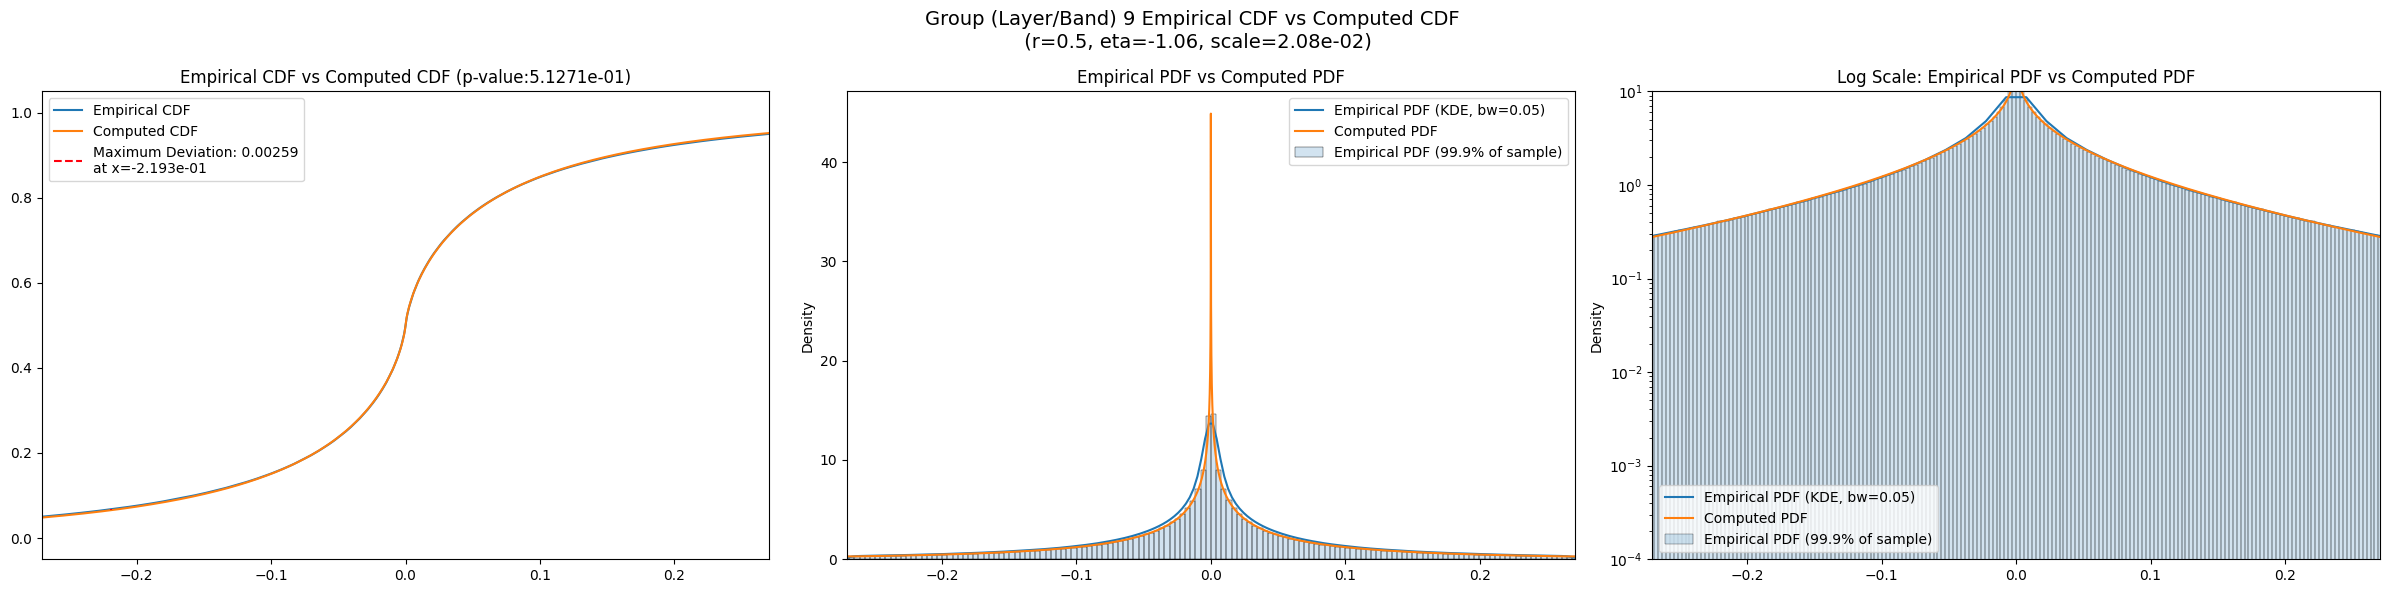

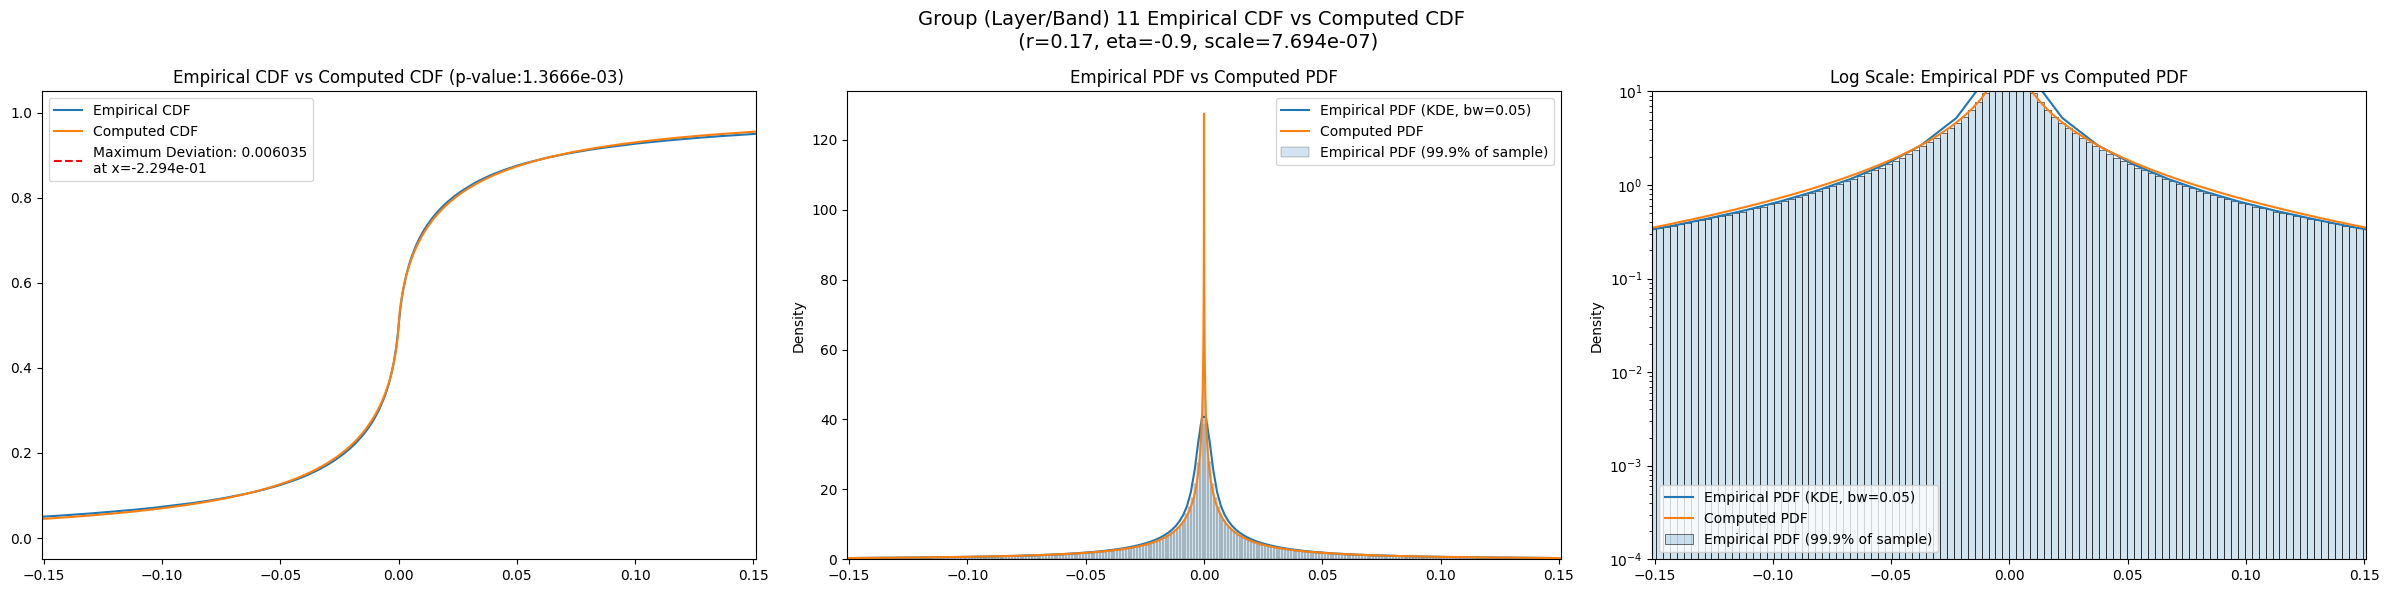

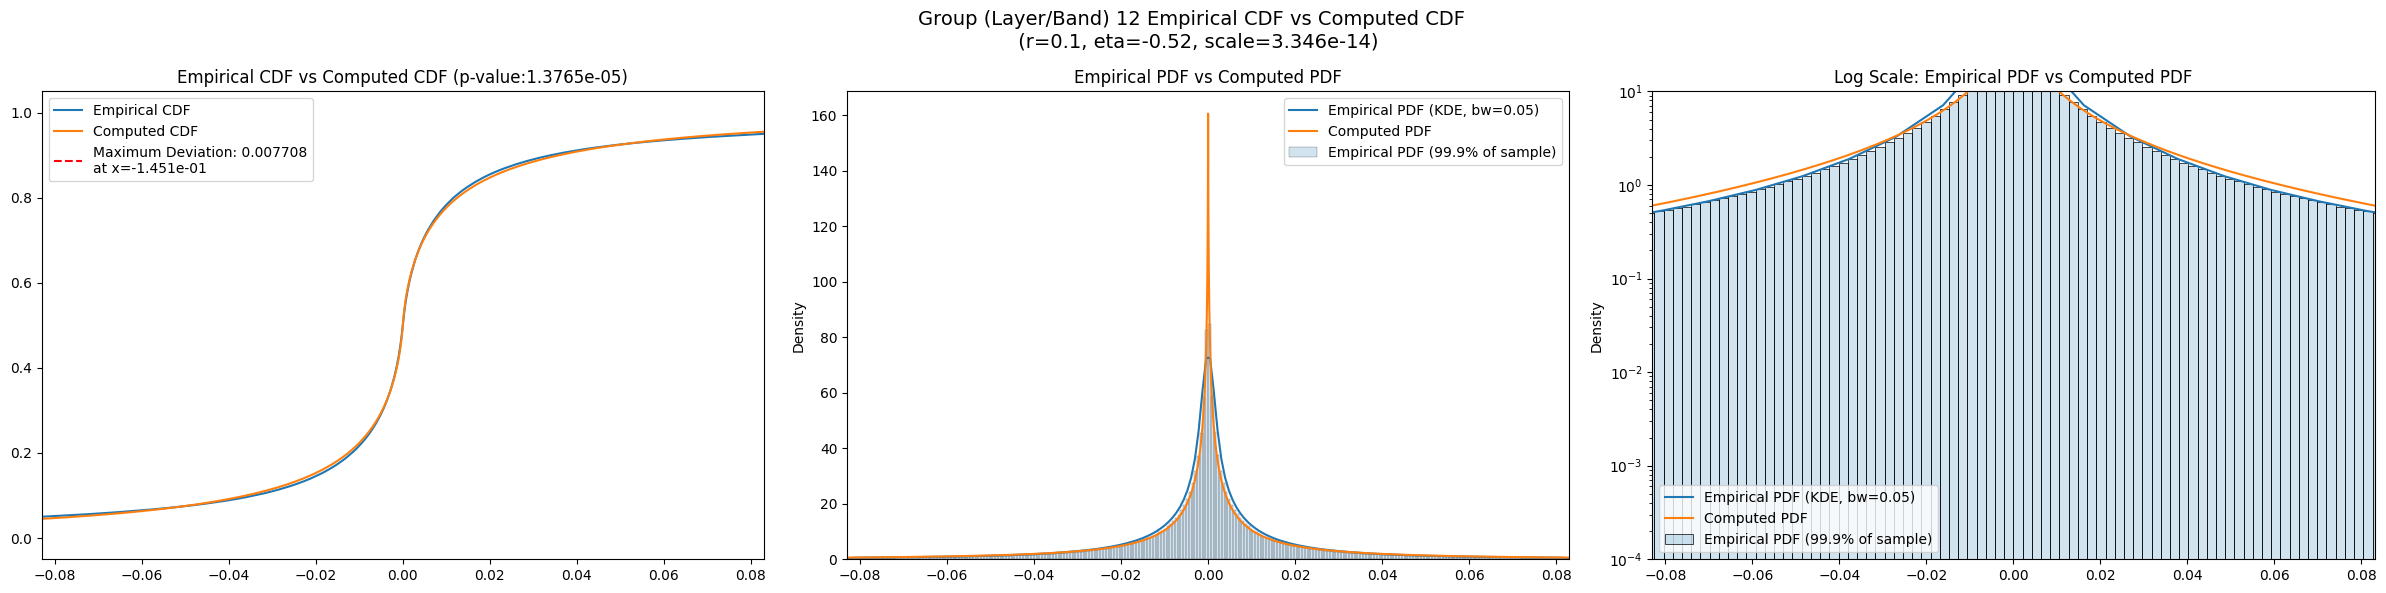

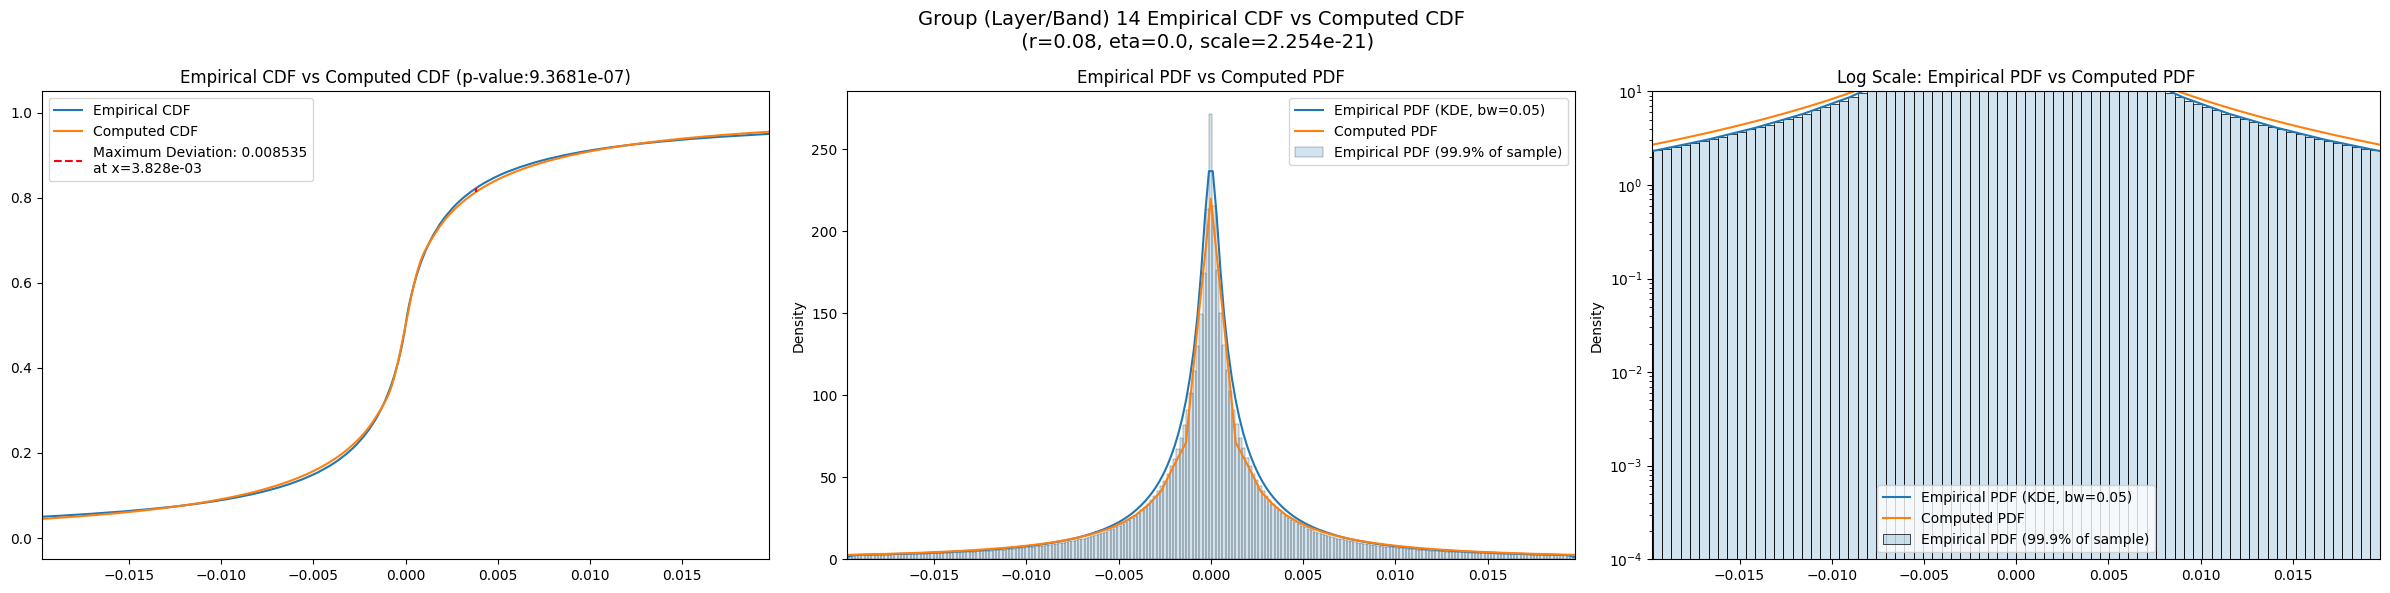

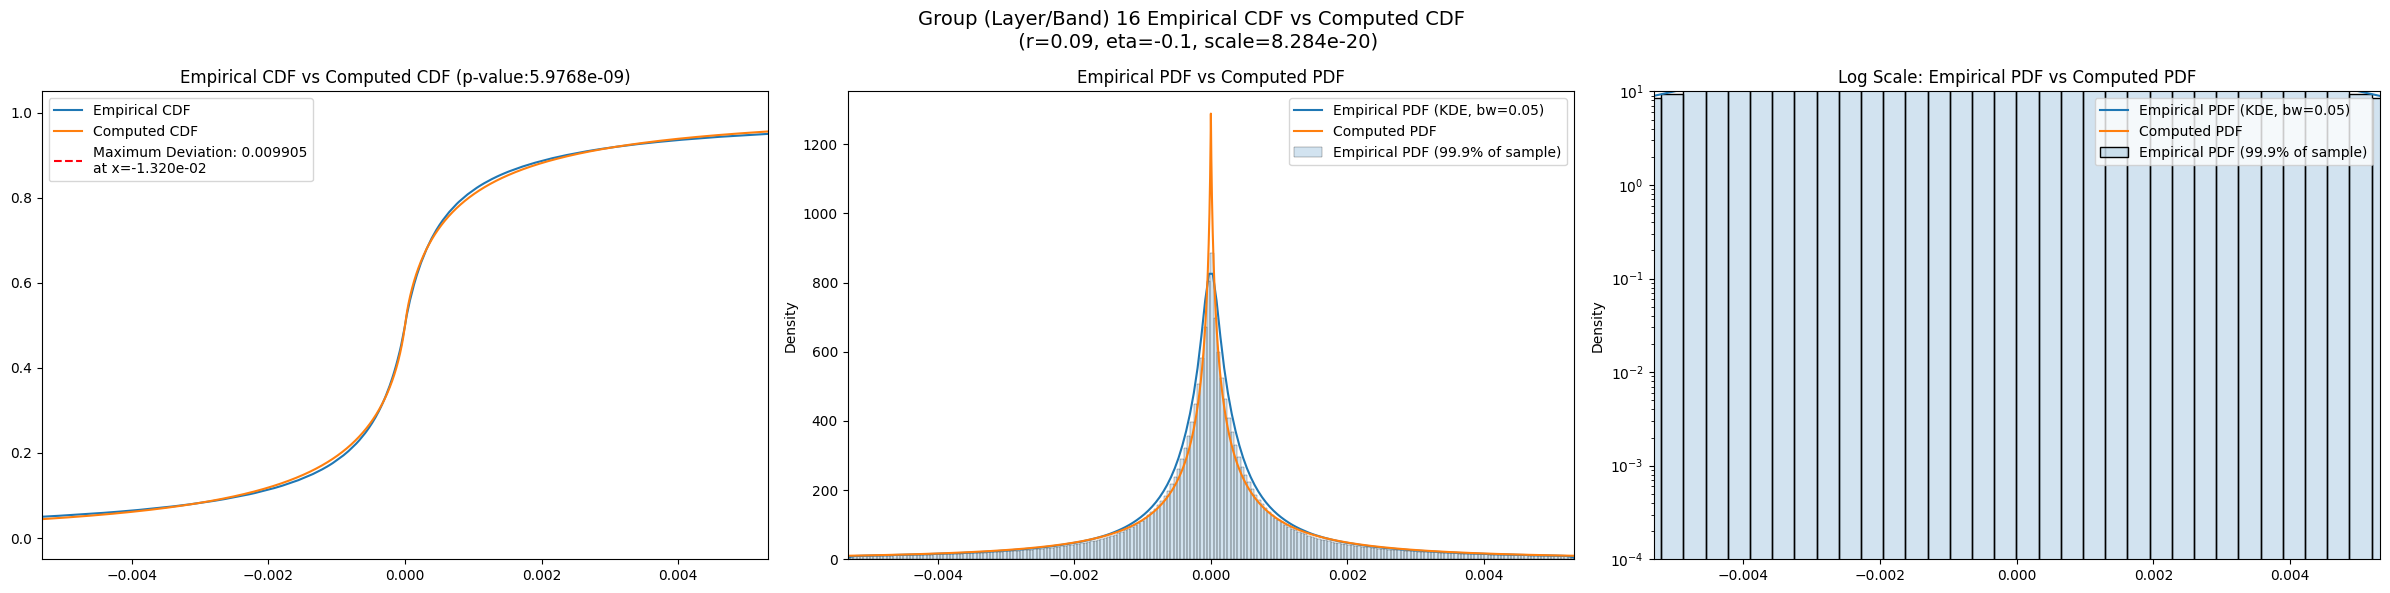

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.012916   0.010740   0.015637   51.336946   22.817850   84.237065   
3     0.217873   0.183152   0.256395   40.707511   32.092322   50.155179   
5     2.125036   1.956604   2.298565    7.816209    6.816256    8.903308   
6     1.609258   1.481443   1.740564    7.801211    6.922563    8.731483   
8     0.152770   0.132943   0.175851   27.798005   17.132469   42.966426   
9     0.036978   0.032694   0.042336   22.935628   11.524374   56.282324   
11    0.023993   0.020252   0.028238   38.839707   27.353085   60.311904   
12    0.010854   0.008915   0.013248   56.986148   35.428190  112.556587   
14    0.000619   0.000500   0.000798   80.241013   36.024888  254.719182   
16    0.000157   0.000108   0.000230  217.729501   92.213630  520.367386   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2           98143.0             0.003146        0.3         -0.7  ...   
3          100000.0             0.015281        0.1         -0.5  ...   
5          100000.0             0.010534        0.7         -1.2  ...   
6          100000.0             0.011162        0.6         -1.2  ...   
8          100000.0             0.003691        0.4         -1.0  ...   
9          100000.0             0.003153        0.6         -1.1  ...   
11         100000.0             0.008602        0.2         -1.0  ...   
12         100000.0             0.008430        0.1         -0.5  ...   
14         100000.0             0.009664        0.1         -0.3  ...   
16         100000.0             0.010954        0.1         -0.3  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           0.051837              0.056813         8.664960e-276   
3           0.060380              0.084335          0.000000e+00   
5           0.562139              0.090425          0.000000e+00   
6           0.462650              0.089947          0.000000e+00   
8           0.154647              0.072133          0.000000e+00   
9           0.084514              0.070216          0.000000e+00   
11          0.029711              0.089489          0.000000e+00   
12          0.015749              0.085389          0.000000e+00   
14          0.004377              0.078313          0.000000e+00   
16          0.001208              0.077594          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          0.044922             0.030298         1.050250e-78  0.035454   
3          0.054860             0.061838         0.000000e+00  0.041096   
5          0.479292             0.065952         0.000000e+00  0.371091   
6          0.399010             0.065173         0.000000e+00  0.306664   
8          0.133283             0.046337        5.089790e-187  0.104348   
9          0.072534             0.044820        5.295830e-175  0.056793   
11         0.025968             0.065528         0.000000e+00  0.019602   
12         0.013964             0.061760         0.000000e+00  0.010479   
14         0.003919             0.054146        2.961560e-255  0.002970   
16         0.001082             0.053156        5.079950e-246  0.000826   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.032426   4.359560e-90          9.595665e-01  
3          0.056784  1.026630e-280          1.339958e-17  
5          0.067156   0.000000e+00          7.622272e-08  
6          0.065255   0.000000e+00          9.217875e-11  
8          0.047948  3.102670e-200          9.394789e-01  
9          0.046789  1.099620e-190          5.127119e-01  
11         0.063988   0.000

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.003146                 0.004333          0.001615   
3                0.015281                 0.004293          0.014059   
5                0.010534                 0.004293          0.009240   
6                0.011162                 0.004293          0.010907   
8                0.003691                 0.004293          0.001682   
9                0.003153                 0.004293          0.002590   
11               0.008602                 0.004293          0.006035   
12               0.008430                 0.004293          0.007708   
14               0.009664                 0.004293          0.008545   
16               0.010954                 0.004293          0.009905   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.056813             0.030298       0.032426  
3                 0.084335             0.061838       0.056784  
5                 0.090425             0.065952       0.067156  
6                 0.089947             0.065173       0.065255  
8                 0.072133             0.046337       0.047948  
9                 0.070216             0.044820       0.046789  
11                0.089489             0.065528       0.063988  
12                0.085389             0.061760       0.058988  
14                0.078313             0.054146       0.050465  
16                0.077594             0.053156       0.049205

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2               0.009683          0.001615    0.40     -0.82  1.134243e-03   
3               0.151594          0.014059    0.10     -0.55  6.522820e-13   
5               2.125036          0.009240    0.65     -1.20  4.077534e+00   
6               1.501784          0.010907    0.63     -1.20  2.715783e+00   
8               0.141114          0.001682    0.40     -1.03  3.222775e-02   
9               0.034405          0.002590    0.50     -1.06  2.079615e-02   
11              0.022029          0.006035    0.17     -0.90  7.693813e-07   
12              0.009703          0.007708    0.10     -0.52  3.345721e-14   
14              0.000455          0.008545    0.08      0.00  2.253919e-21   
16              0.000029          0.009905    0.09     -0.10  8.284157e-20   

      best_exclude_cutoff  
band                       
2                   100.0  
3                   175.0  
5                     0.0  
6                   100.0  
8                    25.0  
9                    25.0  
11                   25.0  
12                   25.0  
14                  100.0  
16                  550.0